In [1]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sys import getsizeof
import numpy as np
import random
import math
from os.path import isfile
from sklearn.externals.six import StringIO
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from operator import itemgetter
import pydotplus
import igraph as ig
import re
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from scipy.stats import binned_statistic
from collections import *
import cPickle as pickle
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.svm import SVC, SVR
from scipy.sparse import dok_matrix
import MySQLdb as sql
from sklearn import cross_validation
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
db = sql.connect('localhost', 'root', 'root', 'enys')
court = 'cjeu'
cerulean = '#0485d1'
scarlet = '#be0119'
sns.set_style('whitegrid')

Wall time: 32.5 s


In [2]:
%run load_data.py
GRAPH = 'cjeu'
np.random.seed(42)
random.seed(42)


# Find the greatest connected component and work on that
components = []
lengths = []
# Find the greatest component from the undirected version of the graph
for component in nx.connected_component_subgraphs(nx.Graph(G)):
    components.append(component)
    lengths.append(len(component))
# Find the GCC as the largest component and then recreate the directed graph
GCC = components[lengths.index(max(lengths))]
GCC = G.subgraph(GCC.nodes())
GCC.remove_nodes_from(GCC.selfloop_edges())
components = None
lengths = None

In [3]:
# Override methods here
def calc_bag_of_words(court, metric='cosine', max_df=1.0, min_df=1):
    """
    Perform bag-of-words vectorization on the full court dataset of size N and return its rowwise similarity
    
    argument:
    metric -- sklearn supported distance measure
    court -- what court to work on (cjeu or echr)
    
    returns:
    name_to_col -- mapping from node name to column
    col_to_name -- mapping from column to node name
    X -- NxN matrix of similarites
    """
    def clean_text(t):
        pat = r'[^a-zA-Z\s]'
        t = re.sub(pat, '', t.lower())
        t = " ".join([w for w in t.split(" ") if len(w) > 1])
        t.decode(chardet.detect(t)['encoding'])
        return t
    if isfile('pickles/{}_bow.pkl'.format(court)):
        name_to_col, col_to_name, X = pickle.load(open('pickles/{}_bow.pkl'.format(court), 'rb'))
    else:
        count_vec = CountVectorizer()
        crs = db.cursor()
        crs.execute("""SET GLOBAL max_allowed_packet=1073741824""")
        crs.execute("""SET SESSION group_concat_max_len=1073741824""")
        # Query that returns string of entire paragraphs indexed by the case ID
        query = """SELECT {0}_cases.case_true_id, 
        GROUP_CONCAT({0}_paragraphs.paragraph_content) 
        FROM {0}_paragraphs 
        INNER JOIN {0}_cases ON {0}_paragraphs.case_id = {0}_cases.id
        GROUP BY case_id""".format(court)
        crs.execute(query)
        data = zip(*crs.fetchall())
        data = (data[0], map(clean_text, data[1]))
        name_to_col = {d:i for i,d in enumerate(data[0])}
        col_to_name = {i:d for i,d in enumerate(data[0])}
        X = count_vec.fit_transform(data[1])
        with open('pickles/{}_bow.pkl'.format(court), 'wb') as fl:
            pickle.dump((name_to_col, col_to_name, X), fl)
    return (name_to_col, col_to_name, 1.0-pairwise_distances(X, metric=metric))

def get_bag_of_words(candidate_edges, G, court=GRAPH, metric='cosine'):
    """
    Return bag of words cosine similarity
    """
    results = []
    name_to_col, col_to_name, X = calc_bag_of_words(court, metric)
    for x,y,_ in candidate_edges:
        try:
            s = X[name_to_col[x], name_to_col[y]]
        except KeyError:
            s = 0.0
        results.append((x,y,{'score': s}))
    return results

def calc_tf_idf(court, metric='cosine', max_df=0.75, min_df=1):
    """
    Perform tf-idf vectorization on the full court dataset of size N and return its rowwise similarity
    
    argument:
    metric -- sklearn supported distance measure
    court -- what court to work on (cjeu or echr)
    
    returns:
    name_to_col -- mapping from node name to column
    col_to_name -- mapping from column to node name
    X -- NxN matrix of similarites
    """
    def clean_text(t):
        pat = r'[^a-zA-Z\s]'
        t = re.sub(pat, '', t.lower())
        t = " ".join([w for w in t.split(" ") if len(w) > 1])
        return t
    if isfile('pickles/{}_tfidf_{}_{}.pkl'.format(court, max_df, min_df)):
        name_to_col, col_to_name, X = pickle.load(open('pickles/{}_tfidf_{}_{}.pkl'.format(court, max_df, min_df), 'rb'))
    else:
        tf_idf_vec = TfidfVectorizer(decode_error='ignore', max_df=max_df, min_df=min_df)
        crs = db.cursor()
        crs.execute("""SET GLOBAL max_allowed_packet=1073741824""")
        crs.execute("""SET SESSION group_concat_max_len=1073741824""")
        # Query that returns string of entire paragraphs indexed by the case ID
        query = """SELECT {0}_cases.case_true_id, 
        GROUP_CONCAT({0}_paragraphs.paragraph_content) 
        FROM {0}_paragraphs 
        INNER JOIN {0}_cases ON {0}_paragraphs.case_id = {0}_cases.id
        GROUP BY case_id""".format(court)
        crs.execute(query)
        data = zip(*crs.fetchall())
        data = (data[0], map(clean_text, data[1]))
        name_to_col = {d:i for i,d in enumerate(data[0])}
        col_to_name = {i:d for i,d in enumerate(data[0])}
        X = tf_idf_vec.fit_transform(data[1])
        with open('pickles/{}_tfidf_{}_{}.pkl'.format(court, max_df, min_df), 'wb') as fl:
            pickle.dump((name_to_col, col_to_name, X), fl)
    return (name_to_col, col_to_name, 1.0-pairwise_distances(X, metric=metric))

def get_tf_idf(candidate_edges, G, court=GRAPH, metric='cosine', max_df=0.75, min_df=1):
    """
    Return bag of words cosine similarity
    """
    results = []
    name_to_col, col_to_name, X = calc_tf_idf(court, metric, max_df=max_df, min_df=min_df)
    for x,y,_ in candidate_edges:
        try:
            s = X[name_to_col[x], name_to_col[y]]
        except KeyError:
            s = 0.0
        results.append((x,y,{'score': s}))
    return results
    
def successors_scoped(node, head, G):
    """
    Return the successors of a node scoped to the time specified by the head node
    
    arguments:
    node -- node to return successors for
    head -- node containing the timestamp to scope the graph to
    G -- graph containing the nodes
    """
    max_time = G.node[head]['date']
    return [n for n in G[node] if G.node[n]['date'] <= max_time]

def predecessors_scoped(node, head, G):
    """
    Return the predecessors of a node scoped to the time specified by the head node
    
    arguments:
    node -- node to return predecessors for
    head -- node containing the timestamp to scope the graph to
    G -- graph containing the nodes
    """
    max_time = G.node[head]['date']
    return [n for n in G.pred[node] if G.node[n]['date'] <= max_time]

def scoped_neighborhood(node, head_node, G):
    """
    Return the neighborhood of a node at a given timestamp
    
    arguments:
    node -- node to find the neighborhood for
    head_node -- node containing the timestamp to filter the nodes by
    G -- directed graph containing the node
    """
    max_date = G.node[head_node]['date']
    pre = predecessors_scoped(node, head_node, G)
    suc = successors_scoped(node, head_node, G)
    return list(set(pre).union(set(suc)))    
    
def scoped_out_degree(node, head_node, G):
    """
    Return the degree of a node at a given timestamp
    
    arguments:
    node -- node to return the degree for
    head_node -- node containing the timestamp to filter the nodes by
    G -- graph containing the nodes
    """
    max_date = G.node[head_node]['date']
    neighborhood = [n for n in G[node] if G.node[n]['date'] <= max_date]
    return len(neighborhood)

def scoped_in_degree(node, head_node, G):
    """
    Return the degree of a node at a given timestamp
    
    arguments:
    node -- node to return the degree for
    head_node -- node containing the timestamp to filter the nodes by
    G -- graph containing the nodes
    """
    max_date = G.node[head_node]['date']
    neighborhood = [n for n in G.pred[node] if G.node[n]['date'] <= max_date]
    return len(neighborhood)

def scoped_degree(node, head_node, G):
    """
    Return the degree of a node at a given timestamop
    """
    return len(scoped_neighborhood(node, head_node, G))

def get_common_neighbors(x,y,G):
    u = set(scoped_neighborhood(x,x,G))
    v = set(scoped_neighborhood(y,x,G))
    return u.intersection(v)

def get_common_in_neighbors(x,y,G):
    u = set(successors_scoped(x,x,G))
    v = set(predecessors_scoped(y,x,G))
    return u.intersection(v)

def get_common_out_neighbors(x,y,G):
    u = set(successors_scoped(x,x,G))
    v = set(successors_scoped(y,x,G))
    return u.intersection(v)

def get_neighbor_union(x,y,G):
    u = set(scoped_neighborhood(x,x,G))
    v = set(scoped_neighborhood(y,x,G))
    return u.union(v)

def get_common_referrers(x,y,G):
    common_referrers_source = {n for m in successors_scoped(x, x, G) for n in predecessors_scoped(m, x, G)} - {x}
    referrers_to_target = set(predecessors_scoped(y,x,G))
    return common_referrers_source.intersection(referrers_to_target)

    
def common_referrers(validation_set, G, weighting_scheme=None):
    """
    For a given node pair x and y, return the number of nodes that both refer to a node that x also refers and refers to y
    or f(y) intersection g(f(x)) where f returns the predeccessors of a node and g returns the successors
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
 
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        connected = y in G[x]
        if connected:
            G.remove_edge(x,y)
        cn = get_common_referrers(x,y,G)
        if weighting_scheme and weighting_scheme.is_local():
            weights = []
            for z in cn:
                weights.append(weighting_scheme.score(z, x, G) * 1.0)
            s = sum(weights)
        else:
            s = len(cn)
        if weighting_scheme and weighting_scheme.is_global():
            s = s*weighting_scheme.score(x,y,G)
        if len(non_edge) > 2:
            non_edge[2]['score'] = s
            results.append(non_edge)
        else:
            results.append(s)
        if connected:
            G.add_edge(x,y)
    return results

def common_neighbors(validation_set, G, weighting_scheme=None, recalculate=False):
    """
    Perform common neighbors scoring on a list of edges, backed by the database
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    recalculate -- Whether to load edges from the database or recalculate them all    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,GCC)
        if weighting_scheme and weighting_scheme.is_local():
            weights = []
            for z in cn:
                weights.append(weighting_scheme.score(z, x, GCC) * 1.0)
            s = sum(weights)
        else:
            s = len(cn)
        if weighting_scheme and weighting_scheme.is_global():
            s = s*weighting_scheme.score(x,y,GCC)
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def common_out_neighbors(validation_set, G, weighting_scheme=None, recalculate=False):
    """
    Perform common neighbors scoring on a list of edges, backed by the database
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    recalculate -- Whether to load edges from the database or recalculate them all    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_out_neighbors(x,y,GCC)
        if weighting_scheme and weighting_scheme.is_local():
            weights = []
            for z in cn:
                weights.append(weighting_scheme.score(z, x, GCC) * 1.0)
            s = sum(weights)
        else:
            s = len(cn)
        if weighting_scheme and weighting_scheme.is_global():
            s = s*weighting_scheme.score(x,y,GCC)
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results


def common_in_neighbors(validation_set, G, weighting_scheme=None, recalculate=False):
    """
    Perform common neighbors scoring on a list of edges, backed by the database
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    recalculate -- Whether to load edges from the database or recalculate them all    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_in_neighbors(x,y,GCC)
        if weighting_scheme and weighting_scheme.is_local():
            weights = []
            for z in cn:
                weights.append(weighting_scheme.score(z, x, GCC) * 1.0)
            s = sum(weights)
        else:
            s = len(cn)
        if weighting_scheme and weighting_scheme.is_global():
            s = s*weighting_scheme.score(x,y,GCC)
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

class WeightingScheme():
    
    def is_global(self):
        return self.weight_type == "global"
    def is_local(self):
        return self.weight_type == "local"
        

class Jaccard(WeightingScheme):
    
    def __init__(self):
        self.weight_type = "global"
    
    def score(self,x,y,G):
        """
        Perform jaccard scoring on a list of edges

        arguments:
        validation_set -- list of edges to score
        G -- digraph containing the nodes in the edges of the validation set

        returns:
        list of edges with score as an attribute
        """
        u = set(scoped_neighborhood(x,x,G))
        v = set(scoped_neighborhood(y,x,G))
        try:
            s = 1.0*len(u & v)/len(u | v)
        except:
            s = 0.0
        return s
    
class AdamicAdar(WeightingScheme):
    
    def __init__(self):
        self.weight_type = 'local'
        
    def score(self, z, x, G):
        """
        Return the AdamicAdar coefficient for a single neighbor z, scoped to the time of a node x
        
        arguments:
        z -- node to return the AA coefficient for
        x -- node that holds the timestamp to scope z to
        G -- graph containing x and z
        """
        deg = scoped_degree(z,x,G)
        if deg > 1:
            return 1.0/math.log(scoped_degree(z, x, G))
        else:
            return 0.0

        
class ResourceAllocation(WeightingScheme):
    
    def __init__(self):
        self.weight_type = 'local'
        
    def score(self, z, x, G):
        """
        Return the RA coefficient for a single neighbor z, scoped to the time of a node x
        
        arguments:
        z -- node to return the AA coefficient for
        x -- node that holds the timestamp to scope z to
        G -- graph containing x and z
        """
        deg = scoped_degree(z,x,G)
        if deg > 1:
            return 1.0/scoped_degree(z, x, G)
        else:
            return 0.0


        
class LeichtHolmeNewman(WeightingScheme):
    
    def __init__(self):
        self.weight_type = 'global'
        
    def score(self, x, y, G):
        """
        Return the RA coefficient for a single neighbor z, scoped to the time of a node x
        
        arguments:
        z -- node to return the AA coefficient for
        x -- node that holds the timestamp to scope z to
        G -- graph containing x and z
        """
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg > 0 and y_deg > 0:
            return 1.0/x_deg*y_deg
        else:
            return 0.0

class HubDepressed(WeightingScheme):
    def __init__(self):
        self.weight_type = 'local'

    def score(self, x, y, G):
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg != 0 and y_deg != 0:
            return 1.0/min(x_deg, y_deg)
        else:
            return 0.0
    
class HubPromoted(WeightingScheme):
    def __init__(self):
        self.weight_type = 'global'

    def score(self, x, y, G):
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg != 0 or y_deg != 0:
            return 1.0/max(x_deg, y_deg)
        else:
            return 0.0

class Salton(WeightingScheme):
    def __init__(self):
        self.weight_type = 'global'


    def score(self, x, y, G):
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg != 0 and y_deg != 0:
            return 1.0/math.sqrt(x_deg*y_deg)
        else:
            return 0.0

def hub_depressed(validation_set, G):
    """
    Find the hub promoted similarity of a single edge
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) != 0 and scoped_in_degree(y, x, G) != 0:
            s = 1.0*len(cn)/min(scoped_out_degree(x, x, G),scoped_in_degree(y, x, G))
        else:
            s = 0.0
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def hub_promoted(validation_set, G):
    """
    Find the hub promoted similarity of a single edge
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) != 0 or scoped_in_degree(y, x, G) != 0:
            s = 1.0*len(cn)/max(scoped_out_degree(x, x, G),scoped_in_degree(y, x, G))
        else:
            s = 0.0
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def salton(validation_set, G):
    """
    Find the salton similarity of a single edge
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) == 0 or scoped_in_degree(y, x, G) == 0:
            s = 0.0
        else:
            s = 1.0*len(cn)/math.sqrt(scoped_out_degree(x, x, G)*scoped_in_degree(y, x, G))
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def leicht_holme_newman(validation_set, G):
    """
    Perform LHN1 scoring on a single edge
    
    arguments:
    non_edge -- edge tuple specified by node endpoints
    G -- graph containing the nodes in the edge
    
    return:
    edges with the score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) == 0 or scoped_in_degree(y, x, G) == 0:
            s = 0.0
        else:
            s = 1.0*len(cn)/(scoped_out_degree(x, x, G)*scoped_in_degree(y, x, G))
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def adamic_adar(validation_set, G):
    """
    Perform jaccard scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        neighbors = get_common_neighbors(x,y,G)
        s = 1*sum([1.0/math.log(scoped_degree(node, x, G) + 1) for node in neighbors if scoped_degree(node, x, G) >= 1])
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def adamic_adar_out(validation_set, G):
    """
    Return directed adamic adar scoring for Gamma_out(x) and Gamma_out(y)
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        neighbors = get_common_out_neighbors(x,y,G)
        s = 0.0
        for z in neighbors:
            d = scoped_in_degree(z,x,G)
            if d > 0:
                s += 1.0/math.log(d**2+1)
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def adamic_adar_in(validation_set, G):
    """
    Return directed adamic adar scoring for Gamma_out(x) and Gamma_in(y)
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        neighbors = get_common_in_neighbors(x,y,G)
        s = 0.0
        for z in neighbors:
            d = scoped_in_degree(z,x,G)*scoped_out_degree(z,x,G)
            if d > 0:
                s += 1.0/math.log(d+1)
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def resource_allocation(validation_set, G):
    """
    Perform resource allocation scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        neighbors = get_common_neighbors(x,y,G)
        s = sum([1.0/scoped_degree(node, x, G) for node in neighbors if scoped_degree(node, x, G) >= 1])
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def resource_allocation_out(validation_set, G):
    """
    Perform resource allocation scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        neighbors = get_common_out_neighbors(x,y,G)
        s = sum([1.0/scoped_degree(node, x, G) for node in neighbors if scoped_degree(node, x, G) >= 1])
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results


def preferential_attachment(validation_set, G):
    """
    Perform preferential attachment scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """

    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        s = (scoped_out_degree(x,x,G))*(scoped_in_degree(y,x,G))
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def triadic_closeness(validation_set, G, census=None, weighting_scheme=None):
    
    results = []
    if census == None:
        census = triadic_distribution(G)
    for non_edge in validation_set:
        
        x = non_edge[0]
        y = non_edge[1]
        connected = y in G[x]
        if connected:
            G.remove_edge(x,y)
        u = set(scoped_neighborhood(x,x,G))
        v = set(scoped_neighborhood(y,x,G))
        cn = u.intersection(v)
        t_score = []
        for z in cn:
            triad = get_triad(x,z,y,G)
            if census[triad] == 0:
                continue
            try:
                F2 = census[triad+30]
            except KeyError:
                F2 = 0.0
            try:
                F1 = census[triad+10]
            except KeyError:
                F1 = 0.0
            
            # Add in any weighting schemes that work on the individual nodes in the common neighborhood
            if weighting_scheme and weighting_scheme.is_local():
                score = weighting_scheme.score(z, x, GCC)*(1.0*F1 + F2)/census[triad]
            else:
                score = (1.0*F1 + F2)/census[triad]
            
            t_score.append(score)
        s = sum(t_score)
        if weighting_scheme and weighting_scheme.is_global():
            s = s*weighting_scheme.score(x, y, G)
        if len(non_edge) > 2:
            non_edge[2]['score'] = s
            results.append(non_edge)
        else:
            results.append(s)
        if connected:
            G.add_edge(x,y)
    return results

def triadic_distribution(G):
    """
    Return the distribution of closed triad configurations for a graph
    The distribution is labelled as in the paper by Schall
    http://link.springer.com.proxy.findit.dtu.dk/article/10.1007/s13278-014-0157-9
    
    arguments:
    G -- directed graph
    
    returns:
    Dict of labels with counts
    """
    
    # Integer labels as presented in the paper
    TRIAD_NAMES = range(1,10) + range(11, 20) + range(21,30) + range (31, 40)
    census = {name: 0 for name in TRIAD_NAMES}
    for u in G.nodes_iter():
        u_neighbors = list(set(G.successors(u)) | set(G.predecessors(u)))
        for z in u_neighbors:
            z_neighbors = list((set(G.successors(z)) | set(G.predecessors(z))) - {u} )
            for v in z_neighbors:
                name = get_triad(u,z,v, G)
                census[name] += 1
    return census


def get_triad(u,z,v,G):
    """
    Return the triad created by the nodes u,v and z
    This implementation is quite probably awful.
    
    parameters:
    
    u -- starting node
    z -- connecting node
    v -- ending node
    G -- DiGraph containing the nodes
    
    returns:
    Dict containing closed triad counts
    """
    
    u_out = G[u]
    v_out = G[v]
    z_out = G[z]
    id = 0
    
    if v in u_out and u in v_out:
        id = 30
    elif u in v_out:
        id = 20
    elif v in u_out:
        id = 10
    
    if u in z_out and z not in u_out:
        id += 7
        if v in z_out and z not in v_out:
            return id + 2
        elif z in v_out and v not in z_out:
            return id + 1
        elif z in v_out and v in z_out:
            return id
        raise Exception("Error in finding triad")
    elif z in v_out and v not in z_out:
        id += 5
        if z in u_out and u not in z_out:
            return id + 1
        elif z in u_out and u in z_out:
            return id
        raise Exception("Error in finding triad")
    elif z in u_out and u not in z_out:
        id += 3
        if v in z_out and z not in v_out:
            return id + 1
        if v in z_out and z in v_out:
            return id
        raise Exception("Error in finding triad")
    elif z in u_out and u in z_out:
        if v in z_out and z not in v_out:
            return id + 2
        elif v in z_out and z in v_out:
            return id + 1
    
    raise Exception("No triad found")
        

def get_closed_triads(x, y, G):
    """
    Return the closed triads generated by adding a link from x to y.
    Triads are classified according to the triadic_census algorithm of NetworkX based on 
    http://vlado.fmf.uni-lj.si/pub/networks/doc/triads/triads.pdf
    """
    
    # Taken directly from nx.triadic_census source
    TRIAD_NAMES = ('003', '012', '102', '021D', '021U', '021C', '111D', '111U',
                   '030T', '030C', '201', '120D', '120U', '120C', '210', '300')
    census = {name: 0 for name in TRIAD_NAMES}
    
    x_in = set(G.predecessors(x))
    y_in = set(G.predecessors(y))
    x_out = set(G.successors(x))
    y_out = set(G.successors(y))
    
    for node in x_in | y_in | x_out | y_out:
        # y refers to a node that refers to x
        if node in x_in and node in y_out:
            census['030C'] += 1
        # y is being referred to by a node that refers to x
        if node in x_in and node in y_in:
            census['030T'] += 1
        # x refers to a node that refers to y
        if node in x_out and node in y_in:
            census['030T'] += 1
        # x refers to a node that y refers to
        if node in x_out and node in y_out:
            census['030T'] += 1

def time_difference(candidate_edges, G):
    """
    Return the time difference for a set of edges
    """

    results = []
    
    results = [(x,y, {'score': int((G.node[x]['date'] - G.node[y]['date']).days)}) for x,y,_ in candidate_edges]
    return results

def log_time_difference(candidate_edges, G):
    """
    Return the time difference for a set of edges
    """

    results = []
    
    results = [(x,y, {'score': math.log(int((G.node[x]['date'] - G.node[y]['date']).days))}) for x,y,_ in candidate_edges]
    return results

def shortest_dag_path(candidate_edges, G):
    results = []
    longest_possible_path = len(G.nodes())
    H = nx.Graph(G)
    for x,y,_ in candidate_edges:
        connected = y in G[x].keys()
        if connected:
            H.remove_edge(x,y)
        try:
            results.append((x,y,{'score': nx.shortest_path_length(H,x,y)}))
        except:
            results.append((x,y, {'score': longest_possible_path}))
        if connected:
            H.add_edge(x,y)
    return results
        
class CommonNeighbors():
    """
    An experiment that scores a list of edges based on the number of common neighbors between the source and the target node
    """
    
    def __init__(self, weighting_scheme=None):
        self.weighting_scheme = weighting_scheme
        
    def valid_false_edges(self, G, source_nodes):
        """
        Returns a list of edges that do not exist in G and will score highly on the common neighbors index
        
        Parameters
        ----------
        G: networkX.Graph
            Graph to perform experiment on
        source_nodes: list of tuples
            Nodes containing the true edges to be scored
        """
        false_validation_edges = [(source, target) for source in source_nodes
                   for neighbor in G[source].keys()
                   for target in set(scoped_neighborhood(neighbor, source, G)) - {source} if target not in G[source].keys()]
        
        false_validation_edges = list(set(false_validation_edges))
        for i in range(len(false_validation_edges)):
            edge = false_validation_edges[i]
            # Add date information to the non-edge
            false_validation_edges[i] = edge + ({'date': G.node[edge[0]]['date']},)
        
        return false_validation_edges
        
    def score_edges(self, edges, G):
        return common_neighbors(edges, G, self.weighting_scheme)
    
class TriadicCloseness(CommonNeighbors):
    
    def __init__(self, cache_distribution=False, weighting_scheme=None):
        self.cache_distribution = cache_distribution
        self.census = None
        self.weighting_scheme=weighting_scheme
    
    def score_edges(self, edges, G):
        
        if self.cache_distribution == True and self.census == None:
            self.census = triadic_distribution(G)
            return triadic_closeness(edges, G, self.census, self.weighting_scheme)
        else:
            return triadic_closeness(edges, G, self.census, self.weighting_scheme)
    
class CommonReferrers():
    
    def __init__(self, weighting_scheme=None):
        self.weighting_scheme = weighting_scheme
    
    def valid_false_edges(self, G, source_nodes):
        """
        Returns a list of edges that do not exist in G and will score highly on the common referrers index
        
        Parameters
        ----------
        G: networkX.Graph
            Graph to perform experiment on
        source_nodes: list of tuples
            Nodes containing the true edges to be scored
        """
        non_edges = []
        for source in source_nodes:
            neighbors = G[source].keys()
            corefs = set()
            for neighbor in neighbors:
                corefs = corefs | {c for c in predecessors_scoped(neighbor, source, G)}
            [non_edges.append((source, referee)) for coref in (corefs - {source}) 
                                                 for referee in set(successors_scoped(coref, source, G)) - set(neighbors)]
            
        for i in range(len(non_edges)):
            edge = non_edges[i]
            # Add date information to the non-edge
            non_edges[i] = edge + ({'date': G.node[edge[0]]['date']},)
        
        return non_edges
    
    def score_edges(self, edges, G):
        return common_referrers(edges, G, self.weighting_scheme)
            
                
def valid_random_non_edges(graph, n):
    """
    Returns randomized, non-existent links between nodes in the graph that are guaranteed to observe causality.

    Parameters
    ----------
    graph : NetworkX graph.
        Graph to find non-existent edges.
    n : integer
        Number of non-existent edges to find

    Returns
    -------
    non_edges : list
        List of n edges that are not in the graph.
    """
    result_pairs = {}
    # Sort edges according to age
    sorted_edges =[node for node, data in sorted(graph.nodes(data=True), key=lambda x: x[1]['date'], reverse=True)]
    node_set = set(graph.nodes())
    candidates = list(np.random.choice(sorted_edges, n, replace=True))
    i = 0
    while i < len(candidates):
        u = candidates[i]
        if not u in result_pairs.keys():
            result_pairs[u] = []
            
        # Make sure the potential neighbors respect causality with a resolution equal to the timestamp
        cand_index = sorted_edges.index(u)
        potential_neighbors = set(sorted_edges[cand_index:])
        if graph.is_directed():
            neighbors = set(graph.successors(u)).union(set(graph.predecessors(u)))
        else:
            neighbors = set(graph.neighbors(u))
        # Make sure the potential neighbors respect causality
        non_neighbors = list(potential_neighbors - neighbors - set(result_pairs[u]))
        # The oldest node will have a neighborhood of Ø, so add a new candidate to the list in that case
        if len(non_neighbors) == 0:
            candidates.append(random.choice(graph.nodes()))
        else:    
            result_pairs[u].append(random.choice(non_neighbors))
        i += 1
    
    return [(k,v) for k, arr in result_pairs.iteritems() for v in arr]
        

def k_fold_validate(G, k, experiment):
    """
    K-fold validation of some specified function
    
    arguments:
    G -- Graph to perform the function on
    k -- number of folds
    fun -- function to be evaluated
    kwargs -- arguments to be passed to the evaluated function
    
    return:
    List of lists of scored predictions
    """
    results = []
    validation_sets = []
    edges = G.edges(data=True)
    random.shuffle(edges)
    # Find all edges that do not exist in the graph, but will return a high score
    false_edges = experiment.valid_false_edges(G, G.nodes())
    random.shuffle(false_edges)
    M = len(false_edges)/k
    # Find the number of true members in the validation set
    N = len(edges)/k
    for i in range(0,k):
        validation_sets.append(edges[i*N:(i+1)*N] + false_edges[i*M:(i+1)*M])
    for val_edges in validation_sets:
        res = experiment.score_edges(val_edges, G)
        # If not shuffled, subsequent sorting algorithms will always rank true edges higher than false edges when they have
        # the same score
        random.shuffle(res)
        results.append(res)
    return results

def k_fold_nodes(G, k, experiment):
    """
    Perform k-fold validation on the nodes of the graph.
    This validation only tests relevant false edges, i.e. edges where we are fairly certain the score won't come out as 0.0
    making it useful for precision / recall, but not for AUC. The true edges can still score 0.0
    """
    results = []
    nodes = G.nodes()
    random.shuffle(nodes)
    N = len(nodes)/k
    validation_sets = []
    for i in range(0, k):
        validation_sets.append(nodes[i*N:(i+1)*N])
    for true_nodes in validation_sets:
        # Validation sets consist of all possible the edges in 
        val_edges = [(source, target, G[source][target]) for source in true_nodes for target in G[source].keys()]
        val_set = set((source, target) for (source, target, _) in val_edges)
        G_train = G.copy()
        G_train.remove_edges_from(val_edges)
        false_validation_edges = experiment.valid_false_edges(G, true_nodes)
        false_validation_edges = [(x,y,data) for (x,y,data) in false_validation_edges if (x,y) not in val_set]
        validation_set = val_edges + false_validation_edges
        # If not shuffled, subsequent sorting algorithms will always rank true edges higher than false edges when they have
        # the same score
        random.shuffle(validation_set)        
        results.append(experiment.score_edges(validation_set, G))
    return results

def at_degree_validation(G, experiment, degree):
    if degree < 2:
        raise Exception('Degree must be larger than 2')
    res = {}
    H = G.copy()
    to_be_evaluated = []
    # Randomly sample n nodes from each degree bin
    deg=nx.degree(G)
    h = {}
    for node in G.nodes_iter():
        if G.out_degree(node) == degree:
            to_be_evaluated.append(node)
    for node in to_be_evaluated:
        res[node] = []
        e = G.edges(node, data=True)
        if not len(e) == degree:
            raise Exception("Mismatch: {}".format(len(e)))
        G.remove_edges_from(e[1:degree-1])
        for i in range(1, degree):
            to_be_scored = experiment.valid_false_edges(H, [node]) + e[i:degree]
            random.shuffle(to_be_scored)
            scored_edges = experiment.score_edges(to_be_scored, G)
            [edge[2].update({'n_edges': i}) for edge in scored_edges]
            res[node] += scored_edges
            #res[node][i] = scored_edges
            G.add_edge(e[i][0], e[i][1])
    return res
        
def precision(G, results, L):
    """
    Find the ratio of the true positives to trues
    
    arguments:
    G -- graph the results are based on
    results -- list of lists of scored predictions
    L -- number of results to be considered
    
    return:
    List of precisions for each set of results
    """
    # Sort the results with descending scores
    results = [sorted(result, key=lambda x: x[2]['score'], reverse=True) for result in results]
    for res in results:
        if L > len(res):
            raise ArgumentError("L is larger than the number of results")
    edge_set = set(G.edges())
    # True positives exist in both the edge set and the result set
    true_positives = [[(edge[0],edge[1]) for edge in result[0:L] if (edge[0], edge[1]) in edge_set] for result in results]
    return [1.0*len(trues)/L for trues in true_positives]

def per_node_precision(G, results):
    """
    results : dict
        A dict of {node: [e1, e2, ... e_n]} where e is an edge of the form (source, target, {'n_edges': x, 'score': y}) where
        n_edges number of edges the node had when the prediction was made.
    """
    
    m = 43
    # Create a dict that all the edges sorted by score and grouped by n_edges and then node
    s = {n: {k: [] for k in range(1,m+1)} for n in results.iterkeys()}
    for node, node_res in results.iteritems():
        # Sort the entire list of results
        srt = sorted(node_res, key=lambda x: x[2]['score'], reverse=True)
        for x,y,data in srt:
            # Add each result to its proper bin
            s[node][data['n_edges']].append((x,y,{'score': data['score']}))
    precisions = {k: [] for k in range(1,m+1)}
    edge_set = set(G.edges())
    for node, node_res in s.iteritems():
        n = G.out_degree(node)
        for level, results in node_res.iteritems():
            L = n-level
            if len(results) == 0:
                break
            precisions[level].append(1.0*len([(edge[0],edge[1]) for edge in results[0:L] if (edge[0], edge[1]) in edge_set])/L)
    return precisions
    

def precision2(G, results, L):
    """
    Find the ratio of the true positives to trues
    
    arguments:
    G -- graph the results are based on
    results -- list of lists of scored predictions
    L -- number of results to be considered
    
    return:
    List of precisions for each set of results
    """
    # Sort the results with descending scores
    #results = heapq.nlargest(L, results, key=lambda x: x[2]['score'])
    edge_set = set(G.edges())
    # True positives exist in both the edge set and the result set
    true_positives = [(edge[0],edge[1]) for edge in results if (edge[0], edge[1]) in edge_set]
    return 1.0*len(true_positives)/L

def plotLogDegree(G):
	d_in = Counter(G.in_degree())
	y_in = Counter(d_in.values()).values()
	x_in = sorted(set(d_in.values()))
	d_out = Counter(G.out_degree())
	y_out = Counter(d_out.values()).values()
	x_out = sorted(set(d_out.values()))
	plt.loglog(x_in,y_in, 'ro-') # Plot the in degree distribution
	plt.loglog(x_out, y_out, 'bv-') # Plot the out degree distribution
	plt.xlabel('Degree')
	plt.ylabel('Number of nodes')
	plt.legend(['In degree', 'Out degree'])
	plt.legend()
	plt.show()
    
def AUC(G, results):
    """
    Perform n trials where the score of a non-edge and an edge in the result is compared. Count the number of trials where
    the edge had the higher score as n' and the number of times the score was equal as n'' and return the AUC as (n' + n'')/n.
    
    arguments:
    G -- graph the results are based on
    results -- list of lists of scored predictions
    
    return:
    List of precisions for each set of results
    """
    
    edge_set = set(G.edges())
    AUC = []
    for result_set in results:
        true_edges = []
        false_edges = []
        for (x,y,data) in result_set:
            if (x,y) in edge_set:
                true_edges.append((x,y,data))
            else:
                false_edges.append((x,y,data))
        
        random.shuffle(true_edges)
        random.shuffle(false_edges)
        n = len(true_edges)
        n_better = 0.0
        n_same = 0.0
        for i in range(0, n):
            if true_edges[i][2]['score'] > false_edges[i][2]['score']:
                n_better += 1.0
            if true_edges[i][2]['score'] == false_edges[i][2]['score']:
                n_same += 1.0
        AUC.append((n_better + 0.5*n_same)/n)
    return AUC

def in_cluster(candidate_edges, G):
    results = []
    nx.write_gml(G, 'G.gml', stringizer=lambda x: str(x))
    G_i = ig.Graph.Read_GML('G.gml')
    vc = G_i.community_infomap()
    node_to_cluster = {}
    for node, cluster in zip(G_i.vs(), vc.membership):
        node_to_cluster[node['label']] = cluster
    for x,y,data in candidate_edges:
        s = False
        if node_to_cluster[x] == node_to_cluster[y]:
            s = True
        results.append((x,y,{'score': s}))
    return results

def slice_graph_by_year(start_year, end_year, G):
    """
    Returns all nodes created within a range of years
    """
    if datetime.date(start_year, 1, 1) < datetime.date(end_year, 1, 1):
        raise ArgumentError("The starting year must be larger than or equal to the ending year")
    t1 = datetime.date(start_year, 12, 31)
    t2 = datetime.date(end_year, 1, 1)
    
    return [n for n in G.nodes(data=True) if n[1]['date'] >= t2 and n[1]['date'] < t1]

def get_features(G, cand_edges, year, load=True):
    
    def load_or_extract(function, f_name, year, cand_edges, G, load=True, dtype=None):
        path = 'pickles/'+GRAPH+'_'+year+'_'+f_name+'.pkl'
        if isfile(path) and load:
            res = pd.read_pickle(path)[[(x,y) for x,y,_ in cand_edges]]
        else:
            res = pd.Series([data['score'] for x,y, data in function(cand_edges, G)], index=[(x,y) for x,y,_ in cand_edges], dtype=dtype)
            if load:
                res.to_pickle(path)
        return res
                     
    df = pd.DataFrame(index=[(x,y) for x,y,_ in cand_edges])
    true_edges = set(G.edges())
    #df['shortest_path'] = load_or_extract(shortest_dag_path, 'shortest_path', str(year), cand_edges, G, dtype='uint16', load=load)
    df['edge'] = pd.Series([True if (x,y) in true_edges else False for x,y,_ in cand_edges], index=[(x,y) for x,y,_ in cand_edges])
    df['src_degree'] = pd.Series([len(G[x]) for x, _, __ in cand_edges], 
                                 index=[(x,y) for x,y,_ in cand_edges], dtype='uint16')
    df['trg_degree'] = pd.Series([G.in_degree(y) for _, y, __ in cand_edges], 
                                 index=[(x,y) for x,y,_ in cand_edges], dtype='uint16')
    df['preferential_attachment'] = load_or_extract(preferential_attachment, 'preferential_attachment', 
                                                    str(year), cand_edges, G, dtype='uint32', load=load)
    df['adamic_adar'] = load_or_extract(adamic_adar, 'adamic_adar', str(year), cand_edges, G, load)
    df['adamic_adar_out'] = load_or_extract(adamic_adar_out, 'adamic_adar_out', str(year), cand_edges, G, load)
    df['adamic_adar_in'] = load_or_extract(adamic_adar_in, 'adamic_adar_in', str(year), cand_edges, G, load)
    df['leicht_holme_newman'] = load_or_extract(leicht_holme_newman, 
                                                'leicht_holme_newman', str(year), cand_edges, G, load)
    df['resource_allocation'] = load_or_extract(resource_allocation, 
                                                'resource_allocation', str(year), cand_edges, G, load)
    df['resource_allocation_out'] = load_or_extract(resource_allocation_out, 
                                                'resource_allocation_out', str(year), cand_edges, G, load)
    df['triadic_closeness'] = load_or_extract(triadic_closeness, 'triadic_closeness', str(year), cand_edges, G, load)
    #df['bag_of_words'] = load_or_extract(get_bag_of_words, 'bag_of_words', str(year), cand_edges, G, load)
    df['tf_idf'] = load_or_extract(get_tf_idf, 'tf_idf', str(year), cand_edges, G, load)
    df['in_cluster'] = load_or_extract(in_cluster, 'in_cluster', str(year), cand_edges, G, load)
    df['common_out_neighbors'] = load_or_extract(common_out_neighbors, 'common_out_neighbors', str(year), cand_edges, 
                                                 G, dtype='uint16', load=load)
    df['common_in_neighbors'] = load_or_extract(common_in_neighbors, 'common_in_neighbors', str(year), cand_edges, 
                                                 G, dtype='uint16', load=load)
    df['common_neighbors'] = load_or_extract(common_neighbors, 'common_neighbors', str(year), cand_edges, 
                                                 G, dtype='uint16', load=load)
    df['time_difference'] = load_or_extract(time_difference, 'time_difference', str(year), cand_edges, G, dtype='uint16', load=load)
    df['log_time_difference'] = np.log(df['time_difference'] + 1)
    df['common_referrers'] = load_or_extract(common_referrers, 'common_referrers', str(year), cand_edges, G, dtype='uint16', load=load)

    return df

def get_features_for_community(G, cand_edges, year, load=True):
    
    def load_or_extract(function, f_name, year, cand_edges, G, load=True, dtype=None):
        path = 'pickles/'+GRAPH+'_'+year+'_'+f_name+'.pkl'
        if isfile(path) and load:
            res = pd.read_pickle(path)[[(x,y) for x,y,_ in cand_edges]]
        else:
            res = pd.Series([data['score'] for x,y, data in function(cand_edges, G)], index=[(x,y) for x,y,_ in cand_edges], dtype=dtype)
            if load:
                res.to_pickle(path)
        return res
                     
    df = pd.DataFrame(index=[(x,y) for x,y,_ in cand_edges])
    true_edges = set(G.edges())
    #df['shortest_path'] = load_or_extract(shortest_dag_path, 'shortest_path', str(year), cand_edges, G, dtype='uint16', load=load)
    df['edge'] = pd.Series([True if (x,y) in true_edges else False for x,y,_ in cand_edges], index=[(x,y) for x,y,_ in cand_edges])
    df['src_degree'] = pd.Series([len(G[x]) for x, _, __ in cand_edges], 
                                 index=[(x,y) for x,y,_ in cand_edges], dtype='uint16')
    df['trg_degree'] = pd.Series([scoped_in_degree(y,x,G) for x, y, __ in cand_edges], 
                                 index=[(x,y) for x,y,_ in cand_edges], dtype='uint16')
    df['preferential_attachment'] = load_or_extract(preferential_attachment, 'preferential_attachment', 
                                                    str(year), cand_edges, G, dtype='uint32', load=load)
    df['adamic_adar'] = load_or_extract(adamic_adar, 'adamic_adar', str(year), cand_edges, G, load)
    #df['adamic_adar_out'] = load_or_extract(adamic_adar_out, 'adamic_adar_out', str(year), cand_edges, G, load)
    #df['adamic_adar_in'] = load_or_extract(adamic_adar_in, 'adamic_adar_in', str(year), cand_edges, G, load)
    #df['leicht_holme_newman'] = load_or_extract(leicht_holme_newman, 
    #                                            'leicht_holme_newman', str(year), cand_edges, G, load)
    #df['resource_allocation'] = load_or_extract(resource_allocation, 
    #                                            'resource_allocation', str(year), cand_edges, G, load)
    #df['resource_allocation_out'] = load_or_extract(resource_allocation_out, 
    #                                            'resource_allocation_out', str(year), cand_edges, G, load)
    #df['triadic_closeness'] = load_or_extract(triadic_closeness, 'triadic_closeness', str(year), cand_edges, G, load)
    #df['bag_of_words'] = load_or_extract(get_bag_of_words, 'bag_of_words', str(year), cand_edges, G, load)
    df['tf_idf'] = load_or_extract(get_tf_idf, 'tf_idf', str(year), cand_edges, G, load)
    df['in_community'] = load_or_extract(in_cluster, 'in_cluster', str(year), cand_edges, G, load)
    #df['common_out_neighbors'] = load_or_extract(common_out_neighbors, 'common_out_neighbors', str(year), cand_edges, 
    #                                             G, dtype='uint16', load=load)
    #df['common_in_neighbors'] = load_or_extract(common_in_neighbors, 'common_in_neighbors', str(year), cand_edges, 
    #                                             G, dtype='uint16', load=load)
    df['common_neighbors'] = load_or_extract(common_neighbors, 'common_neighbors', str(year), cand_edges, 
                                                 G, dtype='uint16', load=load)
    df['time_difference'] = load_or_extract(time_difference, 'time_difference', str(year), cand_edges, G, dtype='uint16', load=load)
    #df['log_time_difference'] = np.log(df['time_difference'] + 1)
    df['common_referrers'] = load_or_extract(common_referrers, 'common_referrers', str(year), cand_edges, G, dtype='uint16', load=load)

    return df

def scorer(ground_truth, predictions):
    return average_precision_score(ground_truth, predictions[:,1])

In [4]:
def get_common_neighbors_community(community):
    """
    Get the potential edges (x,y) where x is in the src candidates and x and y share at least one common neighbor
    """
    query = "MATCH (source) --> (neighbor) -- (target) "\
            "WHERE source.community = {} "\
            "AND source.created_at > target.created_at " \
            "OPTIONAL MATCH (source) -[con:CITES]-> (target) " \
            "RETURN source.verdict_id AS source, target.verdict_id AS target, "\
            "count(neighbor) as common_neighbors, con IS NOT NULL AS edge"
    results = graph.run(query.format(community))
    return results
                        
def get_potential_edges_community(source_nodes):
    """
    """
    query = "MATCH (source), (target) "\
            "WHERE source.verdict_id IN {source_nodes} " \
            "AND source.created_at >= target.created_at "\
            "RETURN source.verdict_id AS source_id, target.verdict_id AS target_id"
    results = graph.run(query, source_nodes = source_nodes)

def get_from_community_neo4j(community):
    """
    Return all nodes belonging to a specific community
    """
    query = "MATCH (n {community: {community}}) WITH n.verdict_id AS id RETURN id"
    return graph.run(query, community=community)

def get_tf_idf_():
    name_to_col, col_to_name, X = calc_tf_idf(GRAPH, max_df=0.7, min_df=1)
    tf_idf_ind = np.array(col_to_name.values())
    n = len(tf_idf_ind)
    index = pd.MultiIndex.from_product([tf_idf_ind, tf_idf_ind], names=['source', 'target'])
    return pd.Series(X.reshape([-1,1]).ravel(), index=index, dtype='float32', name="tf_idf")

def get_potential_edges(G, source_nodes):
    """
    Return potential out-edges for a given source node
    """
    return [(source, target, {}) for target in G.nodes() for source in source_nodes if source!=target 
                       and G.node[target]['date'] <= G.node[source]['date']]

In [7]:
# Initiate the neo4j connection
import py2neo as neo
graph = neo.Graph(password='cjeu')

In [308]:
# Create features for each node in each community
for community in range(0,21):
    if isfile('pickles/df_com_{}.pkl'.format(community)):
        continue
    nodes = [record['id'] for record in get_from_community_neo4j(community)]
    pot_edges = get_potential_edges(GCC, nodes)
    get_features_for_community(GCC, pot_edges, 'com_{}'.format(community)).to_pickle('pickles/df_com_{}.pkl'.format(community))

## Create a classifier for the full dataset

To get a baseline of how classification on a mixed dataset we combine the 20 different communities and create a single classifier trained and tested on the entire dataset.

The classifier is validated based on ROC-AUC through 5-fold cross validation.

In [8]:
df = pd.read_pickle('pickles/df_com_{}.pkl'.format(0))
df['community'] = 0
for community in range(1, 10):
    #Read in the computed features for each community
    df2 = pd.read_pickle('pickles/df_com_{}.pkl'.format(community))
    df2['community'] = community
    df = df.append(df2)

In [58]:
features_included = ['common_neighbors', 'tf_idf', 'adamic_adar', 'time_difference', 
                     'preferential_attachment', 'common_referrers']
if isfile('pickles/clfs_full.pkl') and isfile('pickles/predictions_full.pkl'):
    clfs_full = pickle.load(open('pickles/clfs_full.pkl', 'rb'))
    predictions_full = pickle.load(open('pickles/predictions_full.pkl', 'rb'))
else:
    # Perform the 5-fold validation and 
    skf = StratifiedKFold(df['edge'], n_folds=5)
    predictions_full = []
    clfs_full = []
    for train, test in skf:
        X_train = df.ix[train, features_included]
        y_train = df.ix[train, 'edge']
        X_test = df.ix[test, features_included]
        y_test = df.ix[test, ['edge', 'community']]
        clf = RandomForestClassifier(n_estimators=30).fit(X_train, y_train)
        clfs_full.append(clf)
        p = pd.DataFrame(clf.predict_proba(X_test), columns=['p_false', 'p_true'], index=y_test.index)
        p['y_test'] = y_test['edge']
        p['community'] = y_test['community']
        predictions_full.append(p)
    with open('pickles/clfs_full.pkl', 'wb') as fl:
        pickle.dump(clfs_full, fl)
    with open('pickles/predictions_full.pkl', 'wb') as fl:
        pickle.dump(predictions_full, fl)

### Feature correlations

Correlations between the features is checked to ensure that they are at least relatively uncorrelated.

In [12]:
features = X_train.columns.values
corr = df.loc[:, features].corr()

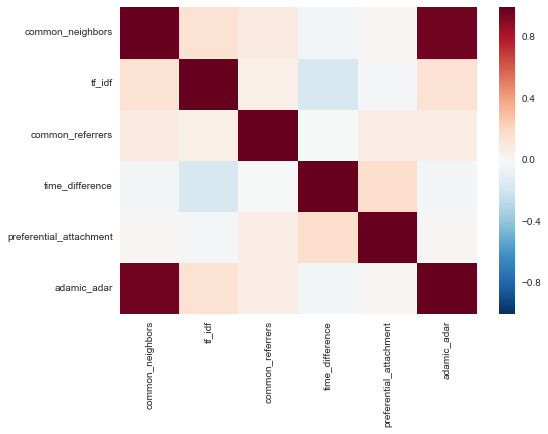

In [13]:
sns.heatmap(corr)

## Feature importances for the full dataset

The importance of each feature is based on the number of splits the feature is involved in as well as the number of samples in the split.

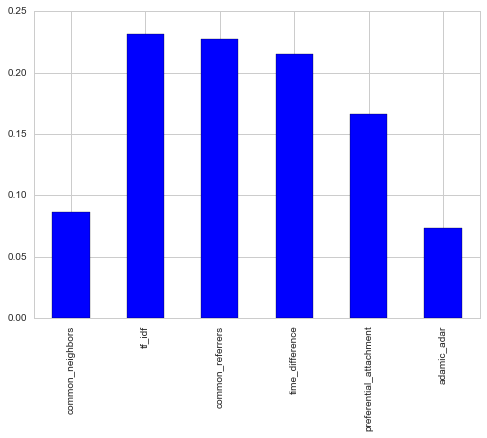

In [11]:
full_importances = pd.DataFrame([clf.feature_importances_ for clf in clfs_full], columns=X_train.columns.values)
full_importances.mean().plot(kind='bar')

The results seen above differ from what I found in the thesis where the CN based similarity indices were far more important than the tf-idf based index. Previously potential edges were found by selecting all potential edges for nodes within a given time slice as follows

$$
E_{test} = (x,y), \ x \in V_{\tau}, \ t_1 \leq \tau \leq t_2, \ y \in V_{t}, \ t < \tau
$$

In this case I have used all potential edges for nodes in the 10 largest communities. This should not make a big difference and another potential source of this is that a different number of features were calculated for the previous dataset.

## Performance on the full dataset

The performance of the classifier on the full dataset is shown below with the ROC-AUC and PR-AUC score being used for benchmarking. 

In [59]:
roc_score = 0.0
pr_score = 0.0
for pred in predictions_full:
    roc_score +=  roc_auc_score(pred['y_test'], pred['p_true'])
    pr_score +=  average_precision_score(pred['y_test'], pred['p_true'])
roc_score_full = roc_score/5.0
pr_score_full = pr_score/5.0
print "Overall ROC-AUC for all nodes: {}".format(roc_score/5.0)
print "Overall PR-AUC for all nodes: {}".format(pr_score/5.0)
tpr, fpr, _= roc_curve(pred['y_test'], pred['p_true'])
precision, recall, _= precision_recall_curve(pred['y_test'], pred['p_true'])

Overall ROC-AUC for all nodes: 0.889071574253
Overall PR-AUC for all nodes: 0.338855286272


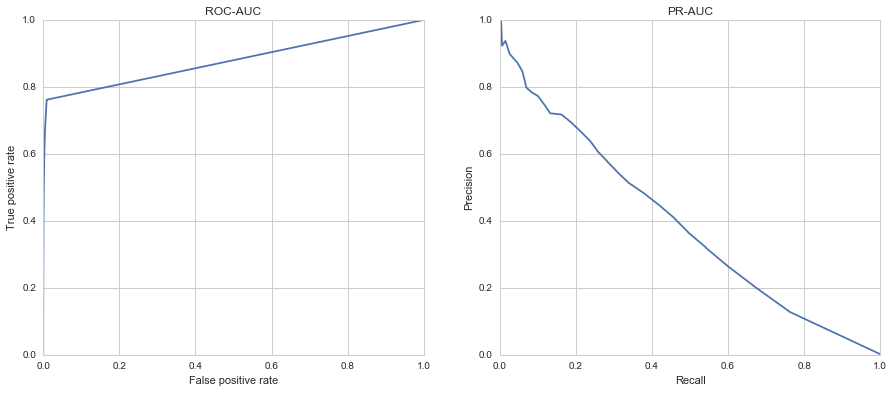

In [60]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(tpr, fpr)
plt.title('ROC-AUC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.subplot(122)
plt.title('PR-AUC')
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')

## Classifier trained on full dataset, different communities

Below the prediction power of the full classifier divided into the ten different communities. The difference in PR-AUC and ROC-AUC for the single communities and the full dataset are shown to highlight whether any communities are easier to predict than others.

In [61]:
preds_all = pd.concat(predictions_full)

In [67]:
community_pr_roc = {}
for community in range(0,10):
    community_pr_roc[community] = {}
    ind = preds_all['community'] == community
    community_pr_roc[community]['pr_roc'] = average_precision_score(preds_all.ix[ind, 'y_test'], preds_all.ix[ind, 'p_true'])
    community_pr_roc[community]['roc_auc'] = roc_auc_score(preds_all.ix[ind, 'y_test'], preds_all.ix[ind, 'p_true'])

In [72]:
for com, res in community_pr_roc.iteritems():
    print "Community {}, pr-auc: {:.4f}, roc-auc: {:.4f}".format(com, (res['pr_roc'] - pr_score_full), (res['roc_auc'] - roc_score_full))

Community 0, pr-auc: -0.0770, roc-auc: -0.0543
Community 1, pr-auc: 0.0348, roc-auc: 0.0457
Community 2, pr-auc: -0.0295, roc-auc: -0.0046
Community 3, pr-auc: -0.0617, roc-auc: -0.0153
Community 4, pr-auc: 0.0294, roc-auc: 0.0305
Community 5, pr-auc: 0.0549, roc-auc: 0.0049
Community 6, pr-auc: -0.0456, roc-auc: -0.0419
Community 7, pr-auc: 0.0457, roc-auc: -0.0905
Community 8, pr-auc: -0.0391, roc-auc: -0.0184
Community 9, pr-auc: 0.0960, roc-auc: 0.0186


As expected some communities do significantly better than others and the results are spread out around the score for the full dataset. A next step from this would be to look at why some communities do better than others. The plot below shows the same PR-AUC differences as the print statements above.

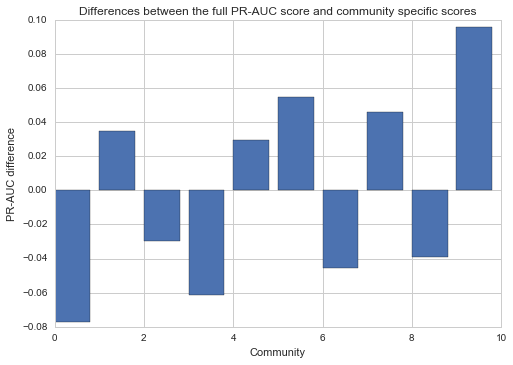

In [78]:
plt.bar(range(0,10), [res['pr_roc'] - pr_score_full for com, res in community_pr_roc.iteritems()])
plt.ylabel('PR-AUC difference')
plt.xlabel('Community')
plt.title('Differences between the full PR-AUC score and community specific scores')

## Properties of nodes in different communities

Here I should look more closely at the properties of nodes in different communities to explain why some are more predictable than others. Properties to look at:
* Degree distributions for communities
* Distributions of publication time (spoiler: I already did this and nodes in the same community are very close in time)
* Avg. clustering coefficient of communities, I expect the ones that are easier to predict to be 'tighter'

Below I'm just showing the imbalance of potential links that share a community vs. the imbalance of all potential links. Since being in the same community correlates with having a link in-community candidate pairs are less imbalanced than the overall case.

In [296]:
ind = df['in_community']
print "Imbalance of all links: {}".format(np.count_nonzero(df['edge'])/float(len(df)))
print "Imbalance of in-community links: {}".format(np.count_nonzero(df[ind].loc[:, 'edge'])/float(len(df[ind])))

Imbalance of all links: 0.00172534985176
Imbalance of in-community links: 0.086803212077


## Classifiers specific for communities

It is interesting to note the performance and importance of different features in the found communities. There are three different approaches to this, looking at a classifier trained on the full dataset and how it performs in different communities which is shown above, training classifiers for the nodes in each community and evaluating them on all potential links and finally creating a classifier for each community and evaluating it on potential, in-community links.

Below I'm tackling the two last cases by making classifiers that are trained on only the potential links for specific communities and classifiers that only look at inbound links for each community.

In [10]:
if isfile('pickles/clfs.pkl') and isfile('pickles/scores.pkl') and isfile('pickles/clfs_in_com.pkl') and isfile('scores_in_com.pkl'):
    clfs = pickle.load('pickles/clfs.pkl')
    scores = pickle.load('pickles/scores.pkl')
    clfs_in_com = pickle.load('pickles/clfs_in_com.pkl')
    scores_in_com = pickle.load('pickles/scores_in_com.pkl')
else:
    features = ['common_neighbors', 'tf_idf', 'common_referrers', 'time_difference', 'preferential_attachment', 'adamic_adar']
    clfs = defaultdict(list)
    scores = defaultdict(list)
    clfs_in_com = defaultdict(list)
    scores_in_com = defaultdict(list)
    for community in range(0, 20):
        # Read in the computed features for each community
        df = pd.read_pickle('pickles/df_com_{}.pkl'.format(community))
        skf = StratifiedKFold(df['edge'], n_folds=5)
        for train, test in skf:
            X_train = df.ix[train, features]
            y_train = df.ix[train, 'edge']
            X_test = df.ix[test, features]
            y_test = df.ix[test, 'edge']
            clf = RandomForestClassifier(n_estimators=30).fit(X_train, y_train)
            clfs[community].append(clf)
            scores[community].append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
        # Find the indices of in-community edges
        com_ind = df['in_community']
        df_in_com = df[com_ind]
        skf = StratifiedKFold(df_in_com['edge'], n_folds = 5)
        for train, test in skf:
            X_train = df_in_com.ix[train, features]
            y_train = df_in_com.ix[train, 'edge']
            X_test = df_in_com.ix[test, features]
            y_test = df_in_com.ix[test, 'edge']
            clf = RandomForestClassifier(n_estimators=30).fit(X_train, y_train)
            clfs_in_com[community].append(clf)
            scores_in_com[community].append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    with open('pickles/clfs.pkl', 'wb') as fl:
        pickle.dump(clfs, fl)
    with open('pickles/scores.pkl', 'wb') as fl:
        pickle.dump(scores, fl)
    with open('pickles/clfs_in_com.pkl', 'wb') as fl:
        pickle.dump(clfs_in_com, fl)
    with open('pickles/scores_in_com.pkl', 'wb') as fl:
        pickle.dump(scores_in_com, fl)
    with open('pickles/predictions_full.pkl', 'wb') as fl:
        pickle.dump(predictions_full, fl)

In [25]:
with open('pickles/clfs.pkl', 'wb') as fl:
    pickle.dump(clfs, fl)
with open('pickles/scores.pkl', 'wb') as fl:
    pickle.dump(scores, fl)
with open('pickles/clfs_in_com.pkl', 'wb') as fl:
    pickle.dump(clfs_in_com, fl)
with open('pickles/scores_in_com.pkl', 'wb') as fl:
    pickle.dump(scores_in_com, fl)
with open('pickles/predictions_full.pkl', 'wb') as fl:
    pickle.dump(predictions_full, fl)

In [16]:
# Average out the scores and feature importances for each community
importances_mean = pd.DataFrame(columns=features)
importances_var = pd.DataFrame(columns=features)
scores_all = pd.DataFrame(columns = ['mean', 'var'])
for community, classifiers in clfs.iteritems():
    importances = np.array([clf.feature_importances_ for clf in clfs[community]])
    importances_mean.loc[community, :] = importances.mean(axis=0)
    importances_var.loc[community, :] = importances.var(axis=0)
    scores_all.loc[community, 'mean'] = np.mean(scores[community])
    scores_all.loc[community, 'var'] = np.var(scores[community])
# Do the same for the in-community results
importances_mean_in_com = pd.DataFrame(columns=features)
importances_var_in_com = pd.DataFrame(columns=features)
scores_all_in_com = pd.DataFrame(columns = ['mean', 'var'])
for community, classifiers in clfs_in_com.iteritems():
    importances = np.array([clf.feature_importances_ for clf in clfs_in_com[community]])
    importances_mean_in_com.loc[community, :] = importances.mean(axis=0)
    importances_var_in_com.loc[community, :] = importances.var(axis=0)
    scores_all_in_com.loc[community, 'mean'] = np.mean(scores_in_com[community])
    scores_all_in_com.loc[community, 'var'] = np.var(scores_in_com[community])

The difference in feature importance between the classifier trained on all communities and the community specific classifiers are shown below. A big difference is that common referrers is consistently more important than it is for the classifier trained on the full dataset and adamic-adar is consistently less important. Also community 7 and 19 are clear outliers that I can look at more.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000040C09160>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000073730358>], dtype=object)

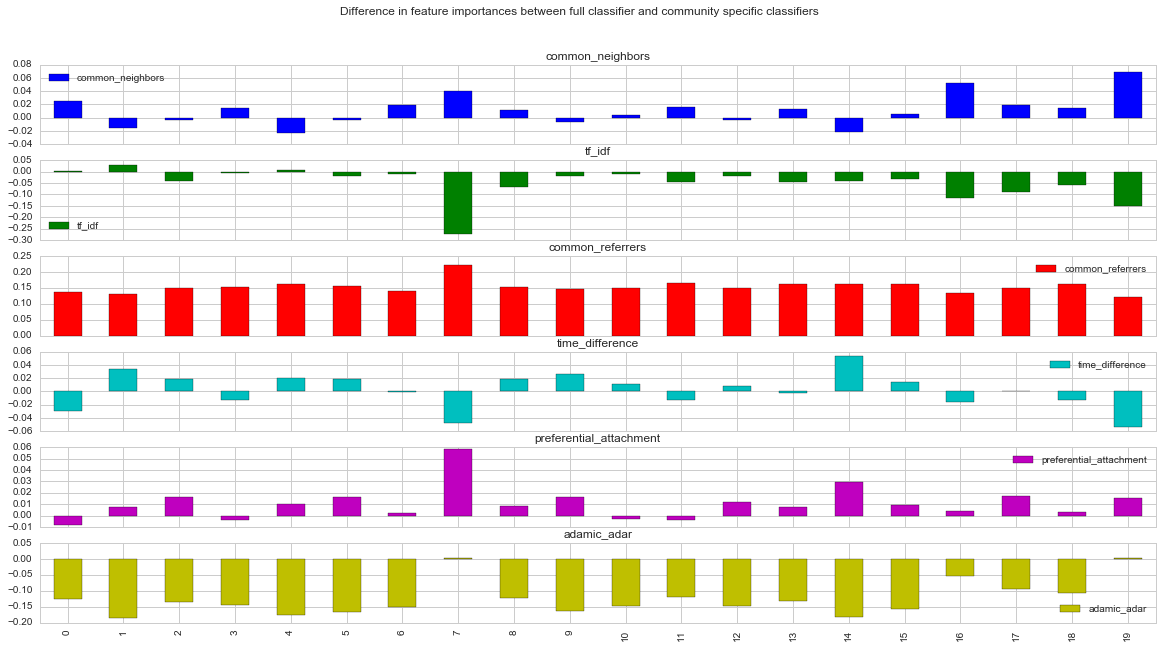

In [84]:
(full_importances.mean() - importances_mean).plot(kind='bar', subplots=True, figsize=(20,10), 
                                                  title='Difference in feature importances between full classifier and community specific classifiers')

The second property to look at is the predictability of the between communities. Interesting thing to note is that the ROC-AUC score seems to be positively correlated with the importance of the common neighbors metric.

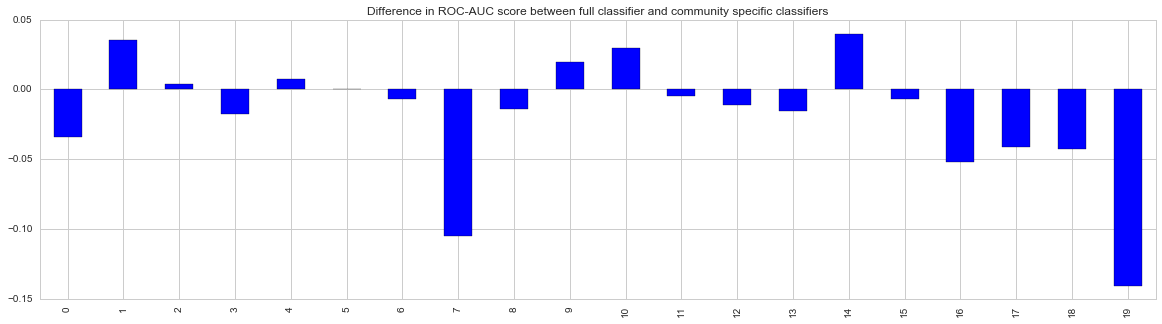

In [83]:
(scores_all.loc[:, 'mean'] - roc_score/5).plot(kind='bar', figsize=(20,5), 
                                               title='Difference in ROC-AUC score between full classifier and community specific classifiers')

Same plots can be seen for the classifiers trained on in community edges. The results are quite similar to the ones for the classifers trained on the full datasets, so I think we can choose one case and focus on that.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000C9F29828>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000545E32B0>], dtype=object)

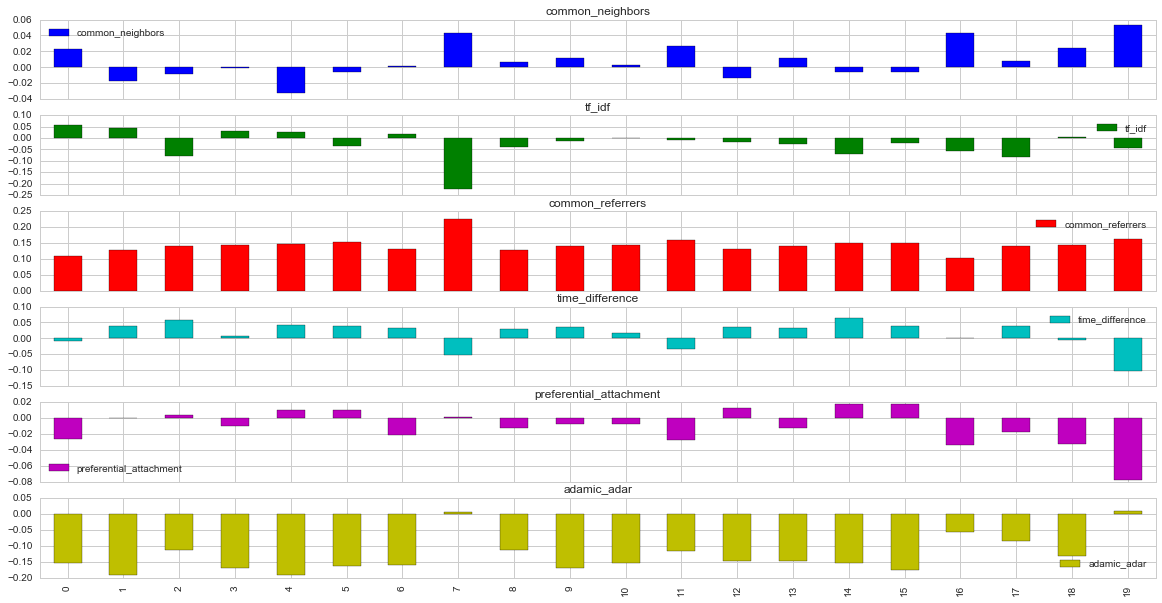

In [22]:
(full_importances.mean() - importances_mean_in_com).plot(kind='bar', subplots=True, figsize=(20,10))

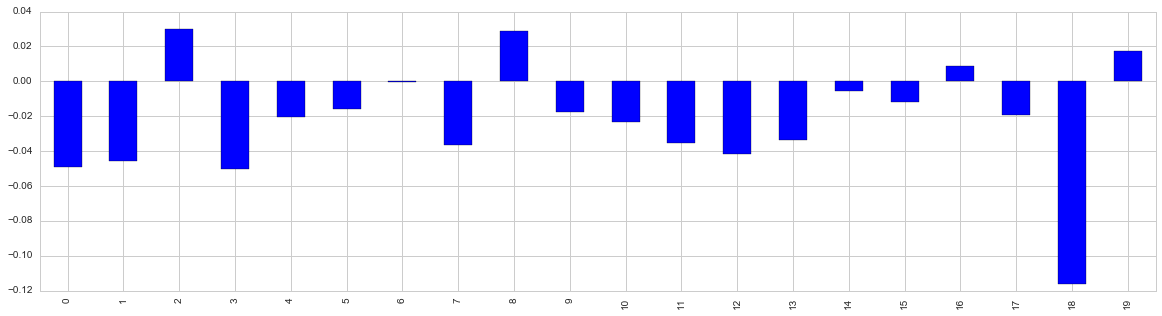

In [20]:
(scores_all_in_com.loc[:, 'mean']-roc_score/5).plot(kind='bar', figsize=(20,5))

# Below here are old results, ignore them

In [4]:
colors = {'red': '#d7191c', 'orange': '#fdae61', 'yellow': '#ffffbf','green':'#abdda4','blue':'#2b83ba'}

In [ ]:
shortest_paths_edges = []
shortest_paths_non_edges = []
# Prepare a single year test set
test_year = 2013
GRAPH = 'cjeu'
nodes_test = [n[0] for n in slice_graph_by_year(test_year, test_year, GCC)]
for node in GCC.nodes_iter():
    neighbors = set(GCC[node].keys())
    for neighbor in list(neighbors):
        GCC.remove_edge(node, neighbor)
        try:
            l = nx.shortest_path_length(GCC, node, neighbor)
        except nx.NetworkXNoPath:
            l = np.nan
        shortest_paths_edges.append((l, (node, neighbor)))
        GCC.add_edge(node, neighbor)
    lens = nx.single_source_shortest_path_length(GCC, node, cutoff=3)
    shortest_paths_non_edges += [(v, (node, k)) for k,v in lens.iteritems() if not k in neighbors]
shortest_paths = shortest_paths_edges + shortest_paths_non_edges

In [16]:
1.0*len(shortest_paths_edges)/len(shortest_paths_non_edges)

0.042118352435391984

In [38]:
edge_len_dict = defaultdict(list)
non_edge_len_dict = defaultdict(list)
for k, v in shortest_paths_edges:
    edge_len_dict[k].append(v)
for k,v in shortest_paths_non_edges:
    non_edge_len_dict[k].append(v)

In [41]:
[len(v) for v in edge_len_dict.itervalues()]

[19150, 87, 20566, 2081, 973, 461, 220, 93, 40, 16, 5, 2]

In [43]:
[len(v) for v in non_edge_len_dict.itervalues()]

[8487, 221631, 807292]

In [46]:
8487*8487

72029169

In [48]:
sum(map(len, non_edge_len_dict.values()))

1037410

In [27]:
%%time
# Prepare a single year test set
test_year = 2013
if isfile('pickles/{}_features.pkl'.format(test_year)):
    test_data = pd.read_pickle('pickles/{}_features.pkl'.format(test_year))
else:
    GRAPH = 'cjeu'
    
    test_data = get_features(GCC, test_candidates, test_year)
    test_data.to_pickle('pickles/{}_features.pkl'.format(test_year))
    nodes_test = get_from_community_neo4j(0)
    test_candidates = get_potential_edges(nodes_test)
    df = get_features()
y_test = test_data['edge']
X_test = test_data.ix[:, [col for col in test_data.columns if col not in ['edge', 'source', 'target']]]
X_test['log_time_difference'] = np.log(X_test['time_difference'] + 1)
X_test['src_degree'] = pd.Series([len(GCC[x]) for x, _, __ in test_candidates], 
                                 index=[(x,y) for x,y,_ in test_candidates], dtype='uint16')
X_test['trg_degree'] = pd.Series([GCC.in_degree(y) for _, y, __ in test_candidates], 
                                 index=[(x,y) for x,y,_ in test_candidates], dtype='uint16')
X_test['preferential_attachment'] = X_test['src_degree']*X_test['trg_degree']
del test_data
print "Test data calculated"

Test data calculated
Wall time: 44.1 s


In [28]:
%%time
# Training set consisting of the nodes of the 3 preceding years 
test_year = 2013
if isfile('pickles/train_{}_features12.pkl'.format(test_year-1)):
    train_data = pd.read_pickle('pickles/train_{}_features12.pkl'.format(test_year-1))
else:
    G_cur = GCC.copy()
    training_years = range(test_year-1, test_year)
    training_years.reverse()
    train_data = []
    for training_year in training_years:
        G_cur.remove_nodes_from([n[0] for n in slice_graph_by_year(2013, training_year+1, G_cur)])
        nodes_train = [n[0] for n in slice_graph_by_year(training_year, training_year, G_cur)]
        train_candidates = [(source, target, {}) for target in G_cur.nodes() for source in nodes_train if source != target
                           and G_cur.node[target]['date'] <= GCC.node[source]['date']]
        train_data.append(get_features(G_cur, train_candidates, training_year))
        print "Year done: {}".format(training_year)
    train_data = pd.concat(train_data)
    train_data.to_pickle('pickles/train_{}_features12.pkl'.format(test_year-1))
y_train = train_data['edge']
X_train = train_data.ix[:, [col for col in train_data.columns if col not in ['edge', 'source', 'target']]]

Wall time: 11.3 s


In [7]:
%%time
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print
        ("")
if isfile('pickles/rf_best_params2.pkl'):
    random_search = pickle.load(open('pickles/rf_best_params2.pkl', 'rb'))
else:
    # build a classifier
    clf = RandomForestClassifier(n_estimators=20)


    # specify parameters and distributions to sample from
    param_dist = {"max_depth": [1, 11, None],
                  "max_features": ['sqrt', 'log2'],
                  "min_samples_split": [1, 11, 51, 100],
                  "min_samples_leaf": [1, 11, 51, 100],
                  "criterion": ["gini", "entropy"]}

    # run randomized search
    n_iter_search = 20
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                       n_iter=n_iter_search, scoring=make_scorer(scorer, needs_proba=True))
    random_search.fit(X_train.astype('float32'), y_train)
    with open('pickles/rf_best_params2.pkl', 'wb') as fl:
        pickle.dump(random_search, fl)
report(random_search.grid_scores_)
top_scores = sorted(random_search.grid_scores_, key=itemgetter(1), reverse=True)[:3]

best_params = top_scores[0].parameters
best_params.update({'warm_start': False, 'oob_score': False, 'n_estimators': 30})

Model with rank: 1
Mean validation score: 0.390 (std: 0.018)
Parameters: {'min_samples_split': 11, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 11}

Model with rank: 2
Mean validation score: 0.386 (std: 0.016)
Parameters: {'min_samples_split': 51, 'max_features': 'log2', 'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 11}

Model with rank: 3
Mean validation score: 0.384 (std: 0.028)
Parameters: {'min_samples_split': 51, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 1}

Wall time: 2.39 s


In [8]:
# Create a subsampled training set for edges with common neighbors
ind = X_train.loc[:, 'common_neighbors'] > 0
X_train_cn = X_train.loc[~y_train, :].loc[ind, :]
X_train_cn = X_train_cn.sample(9*np.count_nonzero(y_train.loc[ind]), weights=X_train_cn['common_neighbors']**2)
y_train_cn = y_train.loc[X_train_cn.index]
assert(np.count_nonzero(y_train_cn) == 0)
X_train_cn = pd.concat([X_train.loc[y_train,:].loc[ind,:], X_train_cn])
y_train_cn = pd.concat([y_train[y_train].loc[ind], y_train_cn])

print "Class imbalance with common neighbors: {:.4f}".format(1.0*np.count_nonzero(y_train_cn)/len(y_train_cn))
print "True edges: {}, Total edges: {}".format(np.count_nonzero(y_train_cn), len(y_train_cn))

Class imbalance with common neighbors: 0.1000
True edges: 7296, Total edges: 72960


In [9]:
%%time
# Feature selection for random forests
from sklearn.feature_selection import RFECV
if isfile('pickles/rfe_forest2.pkl'):
    rfe_forest = pickle.load(open('pickles/rfe_forest2.pkl', 'rb'))
else:
    clf = RandomForestClassifier(**best_params)
    rfe_forest = RFECV(estimator=clf, step=1, cv=StratifiedKFold(y_train_cn, 4), scoring=make_scorer(scorer, needs_proba=True))
    rfe_forest.fit(X_train_cn, y_train_cn)
    with open('pickles/rfe_forest2.pkl', 'wb') as fl:
        pickle.dump(rfe_forest, fl)

Wall time: 677 ms


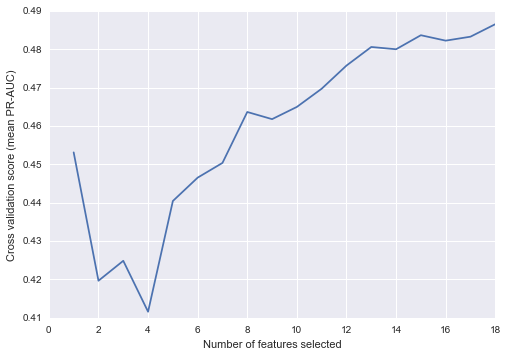

In [10]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mean PR-AUC)")
plt.plot(range(1, len(rfe_forest.grid_scores_) + 1), rfe_forest.grid_scores_)
plt.show()

In [11]:
for name, support in zip(X_train.columns.values, rfe_forest.support_):
    print name, support

src_degree True
trg_degree True
preferential_attachment True
adamic_adar True
adamic_adar_out True
adamic_adar_in True
leicht_holme_newman True
resource_allocation True
resource_allocation_out True
triadic_closeness True
tf_idf True
in_cluster True
common_out_neighbors True
common_in_neighbors True
common_neighbors True
time_difference True
log_time_difference True
common_referrers True


In [13]:
# Create a subsampled training set for edges without common neighbors and degree larger than one
ind = X_train.loc[:, 'common_neighbors'] == 0
# Safely exclude features that will sum to 0
included_features = ['preferential_attachment', 'tf_idf', 'src_degree', 'trg_degree', 
                     'time_difference', 'log_time_difference', 'common_referrers', 'in_cluster']
X_train_no_cn = X_train.loc[~y_train, included_features].loc[ind, included_features]
X_train_no_cn = X_train_no_cn.sample(9*np.count_nonzero(y_train[y_train].loc[ind]), 
                                     weights=X_train_no_cn['preferential_attachment']**2)
y_train_no_cn = y_train.loc[X_train_no_cn.index]
X_train_no_cn = pd.concat([X_train.loc[y_train,included_features].loc[ind,:], X_train_no_cn])
y_train_no_cn = pd.concat([y_train[y_train].loc[ind], y_train_no_cn])

In [14]:
print "Class imbalance, no neighbors, degree > 1: {:.4f}".format(1.0*np.count_nonzero(y_train_no_cn)/len(y_train_no_cn))
print "True edges: {}, Total edges: {}".format(np.count_nonzero(y_train_no_cn), len(y_train_no_cn))

Class imbalance, no neighbors, degree > 1: 0.1000
True edges: 1625, Total edges: 16250


In [15]:
%%time
# Feature selection for random forests
from sklearn.feature_selection import RFECV
if isfile('pickles/rfe_forest_no_cn.pkl'):
    rfe_forest_no_cn = pickle.load(open('pickles/rfe_forest_no_cn.pkl', 'rb'))
else:
    clf = RandomForestClassifier(**best_params)
    rfe_forest_no_cn = RFECV(estimator=clf, step=1, cv=StratifiedKFold(y_train_no_cn, 4), scoring=make_scorer(scorer, needs_proba=True))
    rfe_forest_no_cn.fit(X_train_no_cn, y_train_no_cn)
    with open('pickles/rfe_forest_no_cn.pkl', 'wb') as fl:
        pickle.dump(rfe_forest_no_cn, fl)

Wall time: 230 ms


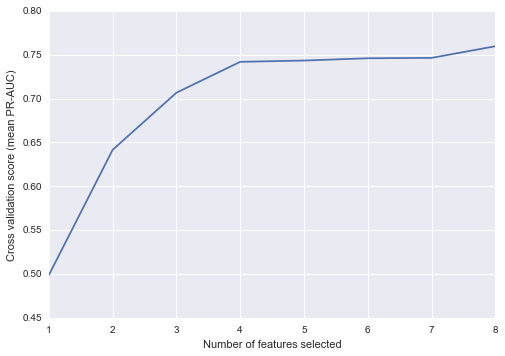

In [16]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mean PR-AUC)")
plt.plot(range(1, len(rfe_forest_no_cn.grid_scores_) + 1), rfe_forest_no_cn.grid_scores_)
plt.show()

In [17]:
for name, support in zip(X_train_no_cn.columns.values, rfe_forest_no_cn.support_):
    print name, support

preferential_attachment True
tf_idf True
src_degree True
trg_degree True
time_difference True
log_time_difference True
common_referrers True
in_cluster True


In [145]:
# Create a subsampled training set for edges with degree one
ind = X_train.loc[:, 'src_degree'] == 1
included_features = ['tf_idf', 'log_time_difference', 'time_difference']
X_train_deg_one=X_train.loc[~y_train, included_features].loc[ind, :]
X_train_deg_one = X_train_deg_one.sample(9*np.count_nonzero(y_train.loc[ind]), 
                                     weights=X_train_deg_one['tf_idf']**2)
y_train_deg_one = y_train.loc[X_train_deg_one.index]
X_train_deg_one = pd.concat([X_train.loc[y_train,included_features].loc[ind,:], X_train_deg_one])
y_train_deg_one = pd.concat([y_train[y_train].loc[ind], y_train_deg_one])

In [116]:
print "Class imbalance, degree 1: {:.4f}".format(1.0*np.count_nonzero(y_train_deg_one)/len(y_train_deg_one))
print "True edges: {}, Total edges: {}".format(np.count_nonzero(y_train_deg_one), len(y_train_deg_one))

Class imbalance, degree 1: 0.1000
True edges: 62, Total edges: 620


In [146]:
%%time
# Feature selection for random forests
from sklearn.feature_selection import RFECV
if isfile('pickles/rfe_forest_deg_one.pkl'):
    rfe_forest_deg_one = pickle.load(open('pickles/rfe_forest_deg_one.pkl', 'rb'))
else:
    clf = RandomForestClassifier(**best_params)
    rfe_forest_deg_one = RFECV(estimator=clf, step=1, cv=StratifiedKFold(y_train_deg_one, 4), scoring=make_scorer(scorer, needs_proba=True))
    rfe_forest_deg_one.fit(X_train_deg_one, y_train_deg_one)
    with open('pickles/rfe_forest_deg_one.pkl', 'wb') as fl:
        pickle.dump(rfe_forest, fl)

Wall time: 1.22 s


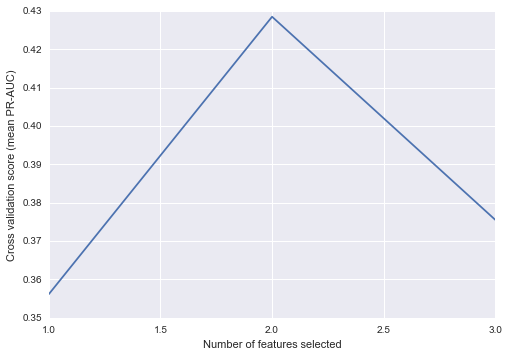

In [147]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mean PR-AUC)")
plt.plot(range(1, len(rfe_forest_deg_one.grid_scores_) + 1), rfe_forest_deg_one.grid_scores_)
plt.show()

In [149]:
for name, support in zip(X_train_deg_one.columns.values, 
                                     rfe_forest_deg_one.support_):
    print name, support

tf_idf True
log_time_difference True
time_difference False


In [18]:
# Create a subsampled test set for edges with common neighbors
ind = X_test.loc[:, 'common_neighbors'] > 0
X_test_cn = X_test.loc[ind, rfe_forest.support_]
y_test_cn = y_test.loc[ind]
# Create a subsampled test set for edges with common neighbors and degree above one
ind = X_test.loc[:, 'common_neighbors'] == 0
included_features = ['preferential_attachment', 'tf_idf', 'src_degree', 'trg_degree', 
                     'time_difference', 'log_time_difference', 'common_referrers', 'in_cluster']
X_test_no_cn = X_test.loc[ind, included_features].loc[:, rfe_forest_no_cn.support_]
y_test_no_cn = y_test.loc[ind]

In [ ]:
cn_preds = rfe_forest.predict_proba(X_test_cn)
no_cn_preds = rfe_forest_no_cn.estimator_.predict_proba(X_test_no_cn)

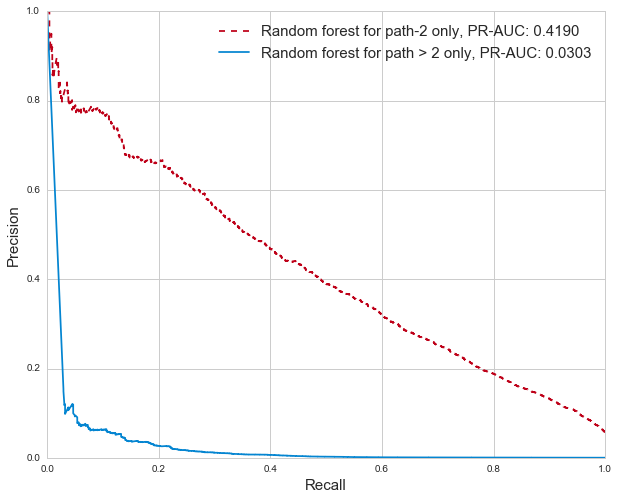

In [39]:
cerulean = '#0485d1'
scarlet = '#be0119'
plt.figure(figsize=(10,8))
prec, reca, _ = precision_recall_curve(y_test_cn, cn_preds[:,1])
av_prec = average_precision_score(y_test_cn, cn_preds[:,1])
plt.plot(reca, prec, linestyle='--', label="Random forest for path-2 only, PR-AUC: {:.4f}".format(av_prec), color=scarlet,)
prec, reca, _ = precision_recall_curve(y_test_no_cn, no_cn_preds[:,1])
av_prec = average_precision_score(y_test_no_cn, no_cn_preds[:,1])
plt.plot(reca, prec, label="Random forest for path > 2 only, PR-AUC: {:.4f}".format(av_prec), color=cerulean)
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.legend(fontsize=15)
plt.show()

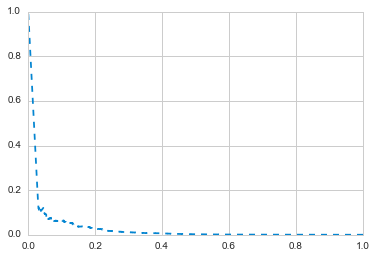

In [35]:
plt.plot(reca, prec, linestyle='--',label="Random forest for path > 2 only, PR-AUC: {}".format(av_prec), color=cerulean)

In [551]:
av_roc

0.88567262203154384

In [467]:
# Create a subsampled test set for edges with common neighbors and degree above one
ind = X_test.loc[:, 'common_neighbors'] == 0
included_features = ['preferential_attachment', 'tf_idf', 'src_degree', 'trg_degree', 
                     'time_difference', 'log_time_difference', 'common_referrers', 'in_cluster']
X_test_no_cn = X_test.loc[ind, included_features].loc[:, rfe_forest_no_cn.support_]
y_test_no_cn = y_test.loc[ind]

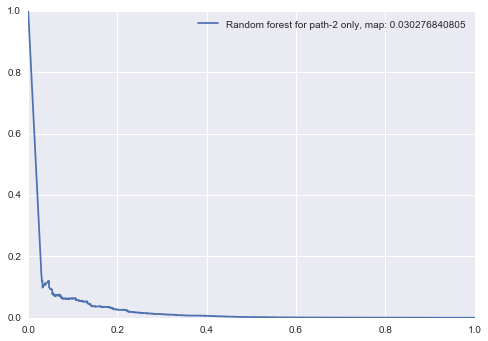

In [21]:
cerulean = '#0485d1'
scarlet = '#be0119'
no_cn_preds = rfe_forest_no_cn.estimator_.predict_proba(X_test_no_cn)
prec, reca, _ = precision_recall_curve(y_test_no_cn, no_cn_preds[:,1])
av_prec = average_precision_score(y_test_no_cn, no_cn_preds[:,1])
plt.plot(reca, prec, label="Random forest for path-2 only, map: {}".format(av_prec))
plt.legend()

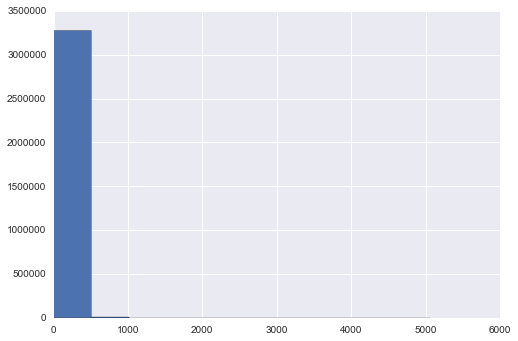

In [198]:
X_test_no_cn.loc[:, 'preferential_attachment'].hist()

In [190]:
# Create a subsampled training set for edges with degree one
ind = X_test.loc[:, 'src_degree'] == 1
included_features = ['tf_idf', 'log_time_difference', 'time_difference']
X_test_deg_one = X_test.loc[ind, included_features].loc[:, rfe_forest_deg_one.support_]
y_test_deg_one = y_test.loc[ind]

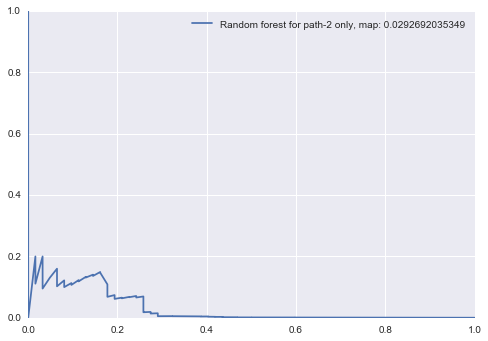

In [191]:
deg_one_preds = rfe_forest_deg_one.estimator_.predict_proba(X_test_deg_one)
prec, reca, _ = precision_recall_curve(y_test_deg_one, deg_one_preds[:,1])
av_prec = average_precision_score(y_test_deg_one, deg_one_preds[:,1])
plt.plot(reca, prec, label="Random forest for path-2 only, map: {}".format(av_prec))
plt.legend()

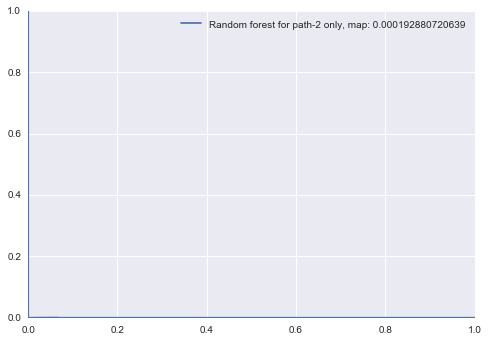

In [378]:
ind = (X_test.loc[:, 'common_neighbors'] == 0)
prec, reca, _ = precision_recall_curve(y_test[ind], preds[ind.values,1])
av_prec = average_precision_score(y_test[ind], preds[ind.values,1])
plt.plot(reca, prec, label="Random forest for path-2 only, map: {}".format(av_prec))
plt.legend()

In [139]:
ind = np.logical_and(X_test.loc[:, 'common_neighbors'] == 0, y_test)

In [145]:
len(y_test[ind])

3370690

In [151]:
len(preds[ind.values, 1])

3370690

In [23]:
np.argmin(clf.feature_importances_)

13

In [27]:
X_train.columns[13]

'common_in_neighbors'

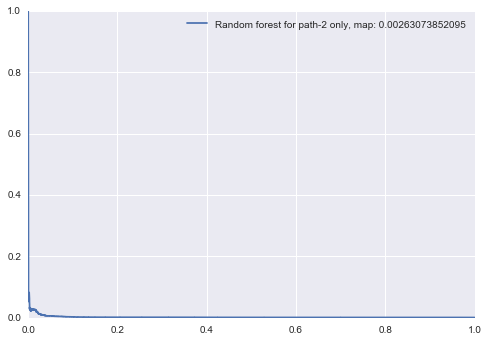

In [209]:
y_test = pd.concat([y_test_cn, y_test_no_cn, y_test_deg_one])
preds = np.concatenate([cn_preds, no_cn_preds, deg_one_preds], axis=0)
prec, reca, _ = precision_recall_curve(y_test, preds[:,1])
av_prec = average_precision_score(y_test, preds[:,1])
plt.plot(reca, prec, label="Random forest for path-2 only, map: {}".format(av_prec))
plt.legend()

In [211]:
print confusion_matrix(y_test, [p >= 0.5 for p in preds[:,1]])

[[3121751  467507]
 [   2487     793]]


In [214]:
print classification_report(y_test_no_cn, [p >= 0.5 for p in no_cn_preds[:,1]])

             precision    recall  f1-score   support

      False       1.00      0.86      0.92   3287009
       True       0.00      0.53      0.00       687

avg / total       1.00      0.86      0.92   3287696



In [535]:
features = list(X_train_no_cn.columns.values)
features2 = list(X_train_cn.columns.values)
importances = {'names': features + features2, 
               'impo': list(rfe_forest_no_cn.estimator_.feature_importances_) + list(rfe_forest.estimator_.feature_importances_),
               'domain': ["Path length > 2"]*len(features) + ["Path length 2"]*len(features2)
              }
importances = pd.DataFrame(importances)

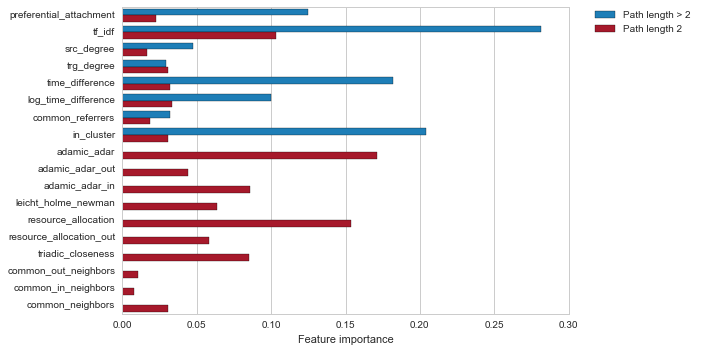

In [537]:
ax = sns.barplot(x ='impo', y='names', hue='domain', data=importances, palette=[cerulean, scarlet])
ax.set_xlabel('Feature importance')
ax.set_ylabel('')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [6]:
lr = LogisticRegression(penalty='l1', C=1).fit(X_train, y_train)

In [7]:
rfe_tree.pdf

array([[  5.44967368e-02,   4.52311513e-02,  -6.15862029e-04,
          1.13048348e+00,   3.22639964e-01,   4.95078287e+00,
          3.24457271e+00,   2.23932598e+00,   7.23048888e+00,
         -2.26582031e-01,   5.78439464e+00,   1.96633371e+00,
          5.99958634e-01,   7.60952010e-02,  -8.69348259e-01,
         -1.85266819e-04,  -2.68460722e-02,   3.60351484e-02]])

In [ ]:
preds = lr.predict_proba(X_test)

In [ ]:
prec, reca, _ = precision_recall_curve(y_test, preds[:,1])
av_prec = average_precision_score(y_test, preds[:,1])
plt.plot(reca, prec, label="Random forest for path-2 only, map: {}".format(av_prec))
plt.legend()

In [ ]:
coefs = {'names': X_train.columns.values, 'impo': lr.coef_[0]}

In [ ]:
sns.barplot(x = 'impo', y='names', data=coefs)

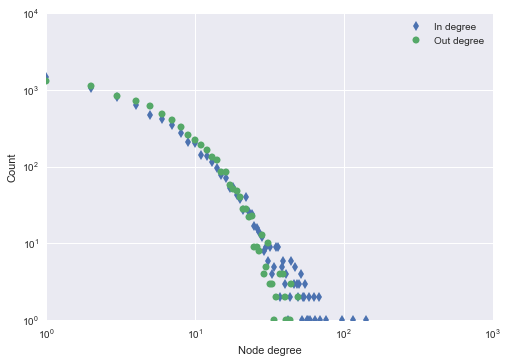

In [27]:
d_in = Counter(GCC.in_degree().values())
x = np.arange(max(d_in.keys()) + 1)
y = np.zeros(max(d_in.keys()) + 1)
for k,v in d_in.iteritems():
    y[k] = v
plt.loglog(x, y, 'd', label='In degree')
d_out = Counter(GCC.out_degree().values())
x = np.arange(max(d_out.keys()) + 1)
y = np.zeros(max(d_out.keys()) + 1)
for k,v in d_out.iteritems():
    y[k] = v
plt.loglog(x, y, 'o', label='Out degree')
plt.xlabel('Node degree')
plt.ylabel('Count')
plt.legend()

## Create time distributions

In [35]:
nodes_by_year = defaultdict(list)
for node in GCC.nodes_iter():
    source_year = GCC.node[node]['date'].year
    for _, y in GCC.out_edges(node):
        trg_year = GCC.node[y]['date'].year
        nodes_by_year[source_year].append(trg_year)

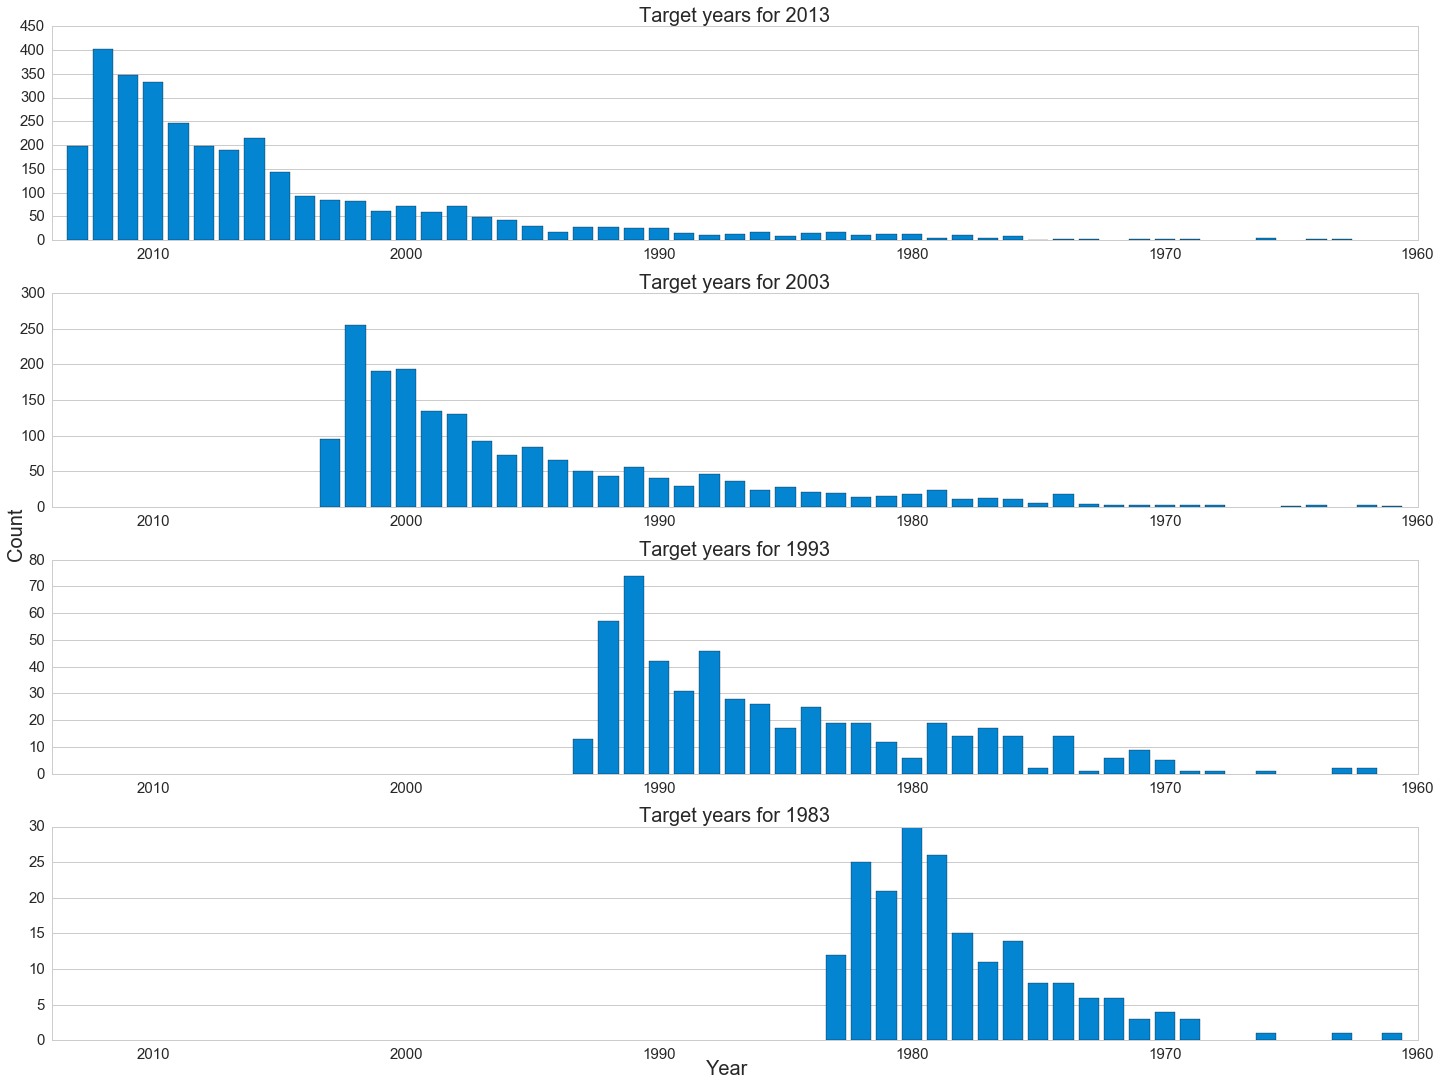

In [343]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,15))
d = Counter(nodes_by_year[2013])
ax[0].bar(d.keys(), d.values(), align='center', color=cerulean)
ax[0].set_xticklabels(list(ax[0].get_xticks().astype(np.int)) + [2013], fontsize=15)
ax[0].set_yticklabels(list(ax[0].get_yticks().astype(np.int)), fontsize=15)
ax[0].set_xlim((2014,1960))
ax[0].set_title('Target years for 2013', fontsize=20)
ax[0].xaxis.grid(False)
year = 2003
d = Counter(nodes_by_year[year])
ax[1].bar(d.keys(), d.values(), align='center', color=cerulean)
ax[1].set_xlim((2014,1960))
ax[1].set_xticklabels(list(ax[1].get_xticks().astype(np.int)) + [year], fontsize=15)
ax[1].set_yticklabels(list(ax[1].get_yticks().astype(np.int)), fontsize=15)
ax[1].set_title('Target years for {}'.format(year), fontsize=20)
ax[1].xaxis.grid(False)
year = 1993
d = Counter(nodes_by_year[year])
ax[2].bar(d.keys(), d.values(), align='center', color=cerulean)
ax[2].set_xlim((2014,1960))
ax[2].set_xticklabels(list(ax[2].get_xticks().astype(np.int)) + [year], fontsize=15)
ax[2].set_yticklabels(list(ax[2].get_yticks().astype(np.int)), fontsize=15)
ax[2].set_title('Target years for {}'.format(year), fontsize=20)
ax[2].xaxis.grid(False)
year = 1983
d = Counter(nodes_by_year[year])
ax[3].bar(d.keys(), d.values(), align='center', color=cerulean)
ax[3].set_xlim((2014,1960))
ax[3].set_xticklabels(list(ax[3].get_xticks().astype(np.int)) + [year], fontsize=15)
ax[3].set_yticklabels(list(ax[3].get_yticks().astype(np.int)), fontsize=15)
ax[3].set_title('Target years for {}'.format(year),fontsize=20)
fig.text(0, 0.5, 'Count', va='center', rotation='vertical', fontsize=20)
fig.text(0.5, 0, 'Year', ha='center', fontsize=20)
ax[3].xaxis.grid(False)
fig.tight_layout()

# Get shortest path length graph

In [175]:
from collections import deque
from heapq import heappush, heappop
from itertools import count
import networkx as nx
from networkx.utils import generate_unique_node

def single_source_shortest_path_length(G,source,cutoff=None):
    """Compute the shortest path lengths from source to all reachable nodes.

    Parameters
    ----------
    G : NetworkX graph

    source : node
       Starting node for path

    cutoff : integer, optional
        Depth to stop the search. Only paths of length <= cutoff are returned.

    Returns
    -------
    lengths : dictionary
        Dictionary of shortest path lengths keyed by target.

    Examples
    --------
    >>> G=nx.path_graph(5)
    >>> length=nx.single_source_shortest_path_length(G,0)
    >>> length[4]
    4
    >>> print(length)
    {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}

    See Also
    --------
    shortest_path_length
    """
    source_date = G.node[source]['date']
    seen={}                  # level (number of hops) when seen in BFS
    level=0                  # the current level
    nextlevel={source:1}  # dict of nodes to check at next level
    while nextlevel:
        thislevel=nextlevel  # advance to next level
        nextlevel={}         # and start a new list (fringe)
        for v in thislevel:
            if v not in seen:
                seen[v]=level # set the level of vertex v
                neighbors = {k: val for k,val in G[v].iteritems() if G.node[k]['date'] <= source_date}
                nextlevel.update(neighbors) # add neighbors of v
        if (cutoff is not None and cutoff <= level):  break
        level=level+1
    return seen  # return all path lengths as dictionary


def all_pairs_shortest_path_length(G, cutoff=None):
    """Computes the shortest path lengths between all nodes in ``G``.

    Parameters
    ----------
    G : NetworkX graph

    cutoff : integer, optional
        Depth at which to stop the search. Only paths of length at most
        ``cutoff`` are returned.

    Returns
    -------
    lengths : dictionary
        Dictionary of shortest path lengths keyed by source and target.

    Notes
    -----
    The dictionary returned only has keys for reachable node pairs.

    Examples
    --------
    >>> G = nx.path_graph(5)
    >>> length = nx.all_pairs_shortest_path_length(G)
    >>> print(length[1][4])
    3
    >>> length[1]
    {0: 1, 1: 0, 2: 1, 3: 2, 4: 3}

    """
    length = single_source_shortest_path_length
    # TODO This can be trivially parallelized.
    return {n: length(G, n, cutoff=cutoff) for n in G}

def bidirectional_shortest_path(G,source,target):
    """Return a list of nodes in a shortest path between source and target.

    Parameters
    ----------
    G : NetworkX graph

    source : node label
       starting node for path

    target : node label
       ending node for path

    Returns
    -------
    path: list
       List of nodes in a path from source to target.

    Raises
    ------
    NetworkXNoPath
       If no path exists between source and target.

    See Also
    --------
    shortest_path

    Notes
    -----
    This algorithm is used by shortest_path(G,source,target).
    """
    # call helper to do the real work
    results=_bidirectional_pred_succ(G,source,target)
    pred,succ,w=results

    # build path from pred+w+succ
    path=[]
    # from source to w
    while w is not None:
        path.append(w)
        w=pred[w]
    path.reverse()
    # from w to target
    w=succ[path[-1]]
    while w is not None:
        path.append(w)
        w=succ[w]

    return path

def _bidirectional_pred_succ(G, source, target):
    """Bidirectional shortest path helper.

       Returns (pred,succ,w) where
       pred is a dictionary of predecessors from w to the source, and
       succ is a dictionary of successors from w to the target.
    """
    source_date = G.node[source]['date']
    # does BFS from both source and target and meets in the middle
    if target == source:
        return ({target:None},{source:None},source)

    # handle either directed or undirected
    if G.is_directed():
        Gpred=G.predecessors_iter
        Gsucc=G.successors_iter
    else:
        Gpred=G.neighbors_iter
        Gsucc=G.neighbors_iter

    # predecesssor and successors in search
    pred={source:None}
    succ={target:None}

    # initialize fringes, start with forward
    forward_fringe=[source]
    reverse_fringe=[target]

    while forward_fringe and reverse_fringe:
        if len(forward_fringe) <= len(reverse_fringe):
            this_level=forward_fringe
            forward_fringe=[]
            for v in this_level:
                for w in Gsucc(v):
                    if G.node[w]['date'] > source_date:
                        continue
                    if w not in pred:
                        forward_fringe.append(w)
                        pred[w]=v
                    if w in succ:  return pred,succ,w # found path
        else:
            this_level=reverse_fringe
            reverse_fringe=[]
            for v in this_level:
                for w in Gpred(v):
                    if G.node[w]['date'] > source_date:
                        continue
                    if w not in succ:
                        succ[w]=v
                        reverse_fringe.append(w)
                    if w in pred:  return pred,succ,w # found path

    raise nx.NetworkXNoPath("No path between %s and %s." % (source, target))


In [178]:
edge_sp = Counter()
for x,y in GCC.edges_iter():
    GCC.remove_edge(x,y)
    try:
        p = bidirectional_shortest_path(nx.Graph(GCC), x, y)
        p = len(p)-1
    except nx.NetworkXNoPath:
        p = np.nan
    edge_sp.update([p])
    GCC.add_edge(x,y)

In [ ]:
sps = all_pairs_shortest_path_length(nx.Graph(GCC), cutoff=13)

In [186]:
non_edge_sp = Counter()
edges = set(GCC.edges())
for x in GCC.nodes_iter():
    neighbors = GCC[x].keys() + GCC.pred[x].keys()
    for y in neighbors:
        sps[x].pop(y, None)
    non_edge_sp.update(sps[x].values())

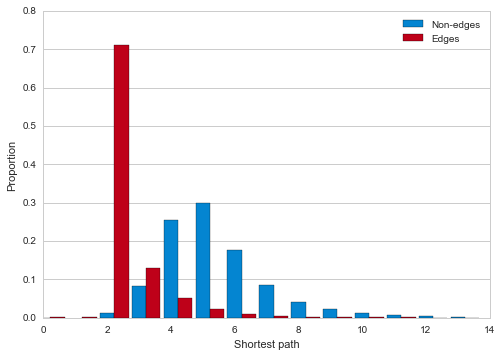

In [480]:
cerulean = '#0485d1'
scarlet = '#be0119'
sns.set_style('whitegrid')
s = sum(non_edge_sp.values())
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, sharex=True)
width= 0.45
ax.bar(non_edge_sp.keys(), [1.0*v/s for v  in non_edge_sp.values()], width=width, label='Non-edges', align='center', color=cerulean)
s = sum(edge_sp.values())
ax.bar(np.array(edge_sp.keys())+width, [1.0*v/s for v in edge_sp.values()], width=width, color=scarlet, label='Edges', align='center')
ax.set_xlim([0, 14])
ax.set_ylabel('Proportion')
ax.set_xlabel('Shortest path')
ax.xaxis.grid(False)
ax.legend()

In [341]:
s = sum(non_edge_sp.values())

[1.0*v/s for v  in non_edge_sp.values()]

[0.00025979606865619197,
 0.012770133736209046,
 0.08156136580253662,
 0.25369808440189057,
 0.2985874353953167,
 0.1776591602906239,
 0.08521154953908235,
 0.041830564481029196,
 0.022097877740361867,
 0.012369971883992853,
 0.007164164303261102,
 0.004242254324680198,
 0.0025476420323594247]

## Find the distribution of common neighbor counts

In [286]:
cn_edges = Counter(X_train.loc[y_train, 'common_neighbors'])
cn_edges = {k: 1.0*v/sum(cn_edges.values()) for k,v in cn_edges.iteritems()}
cn_non_edges = Counter(X_train.loc[~y_train, 'common_neighbors'])
cn_non_edges = {k: 1.0*v/sum(cn_non_edges.values()) for k,v in cn_non_edges.iteritems()}

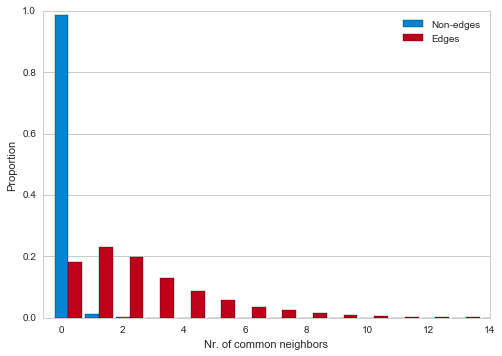

In [291]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, sharex=True)
width= 0.45
ax.bar(cn_non_edges.keys(), cn_non_edges.values(), width=width, label='Non-edges', color=cerulean, align='center')
ax.bar(np.array(cn_edges.keys())+width, cn_edges.values(), width=width, label='Edges', color=scarlet, align='center')
ax.set_xlim([-0.60, 14])
ax.xaxis.grid(False)
ax.set_xlabel('Nr. of common neighbors')
ax.set_ylabel('Proportion')
ax.legend()

In [324]:
e = GCC.edges(data=True)
cn = common_neighbors(e, GCC)

In [332]:
cn_edges = Counter([c[2]['score'] for c in cn])
cn_sum = sum(cn_edges.values())
cn_edges = {k: 1.0*v/cn_sum for k,v in cn_edges.iteritems()}

In [333]:
ind = X_train.loc[:, 'common_neighbors'] > 0
cn_non_edges = Counter(X_train.loc[ind & ~y_train, 'common_neighbors'])
cn_non_sum = sum(cn_non_edges.values())
cn_non_edges = {k: 1.0*v/cn_non_sum for k,v in cn_non_edges.iteritems()}

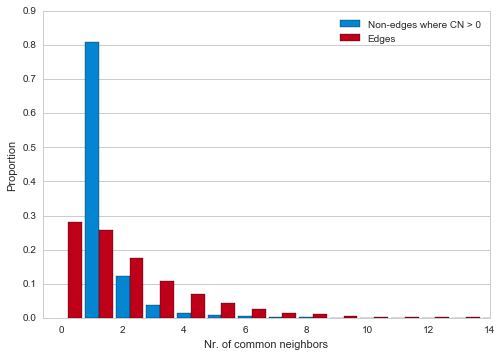

In [334]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, sharex=True)
width= 0.45
ax.bar(cn_non_edges.keys(), cn_non_edges.values(), width=width, label='Non-edges where CN > 0', color=cerulean, align='center')
ax.bar(np.array(cn_edges.keys())+width, cn_edges.values(), width=width, label='Edges', color=scarlet, align='center')
ax.set_xlim([-0.60, 14])
ax.xaxis.grid(False)
ax.set_xlabel('Nr. of common neighbors')
ax.set_ylabel('Proportion')
ax.legend()

# Create correlation map of indices

In [351]:
rho = X_train.corr()

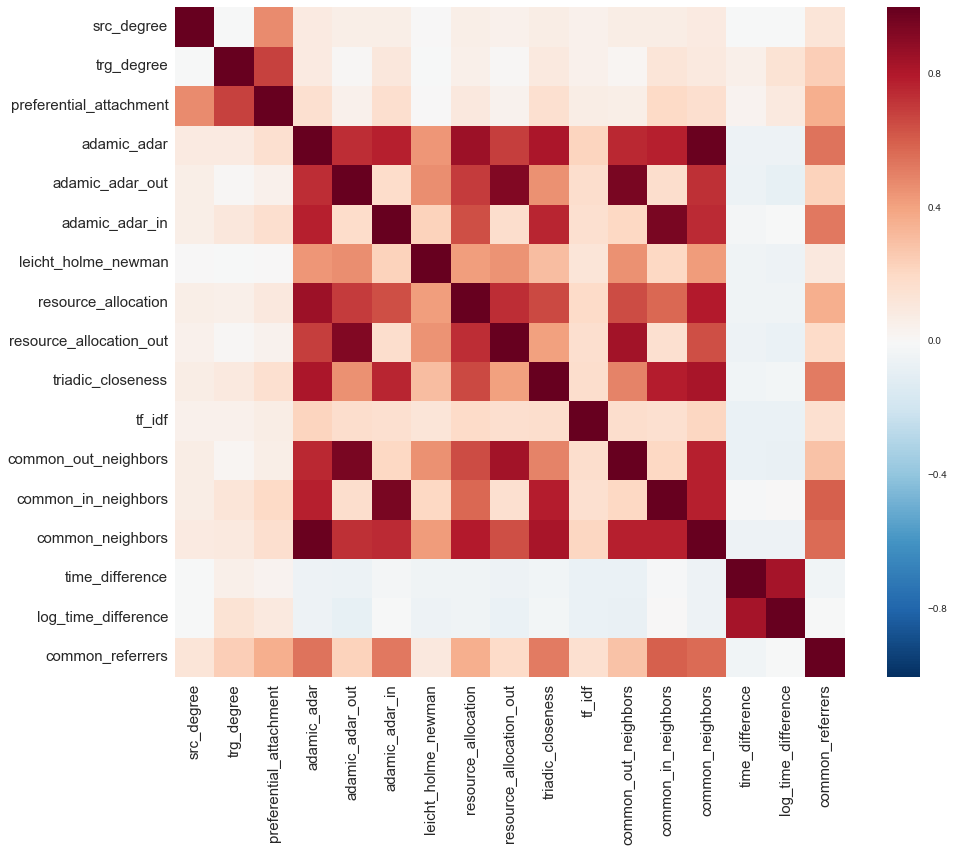

In [363]:
plt.figure(figsize=(15,12))
cmap = sns.heatmap(rho, square=True)
cmap.tick_params(labelsize=15)

# Burstiness

In [372]:
def iter_w_neighbors(iterable):
    """
    Easy access of previous and next item in a list
    """
    iterator = iter(iterable)
    prev = None
    item = iterator.next()  # throws StopIteration if empty.
    for next in iterator:
        yield (prev,item,next)
        prev = item
        item = next
    yield (prev,item,None)

iat = []
for node in GCC.nodes_iter():
    for _, cur_edge, next_edge in iter_w_neighbors(GCC.in_edges_iter(node, data=True)):
        if next_edge:
            iat.append(abs((next_edge[2]['date'] - cur_edge[2]['date']).days) + 1)
iat = np.array(iat)

In [379]:
liat=np.log(iat)

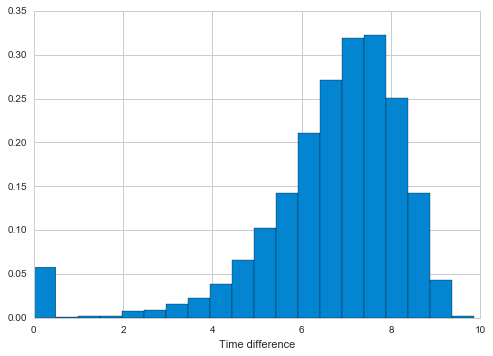

In [390]:
plt.hist(liat, bins=20, color=cerulean,normed=True)
plt.xlabel('Time difference')

In [395]:
m = iat.mean()
sig = iat.std()

In [406]:
(sig-m)/(sig+m)

0.040033823092893953

# Common cluster

In [407]:
# Convert the graph to igraph and find the communities
nx.write_gml(GCC, 'GCC.gml', stringizer=lambda x: str(x))
G_i = ig.Graph.Read_GML('GCC.gml')
# Find the communities in the graph
vc = G_i.community_infomap()

# Create a cluster graph without combining edges and find its adjacency matrix
cg = vc.cluster_graph(combine_edges=False)
A = np.array(cg.get_adjacency().data, dtype=float)

# Proportionalize each row for clearer plotting
row_sums = np.sum(A, axis=0)
A_norm = A / row_sums[:, np.newaxis]

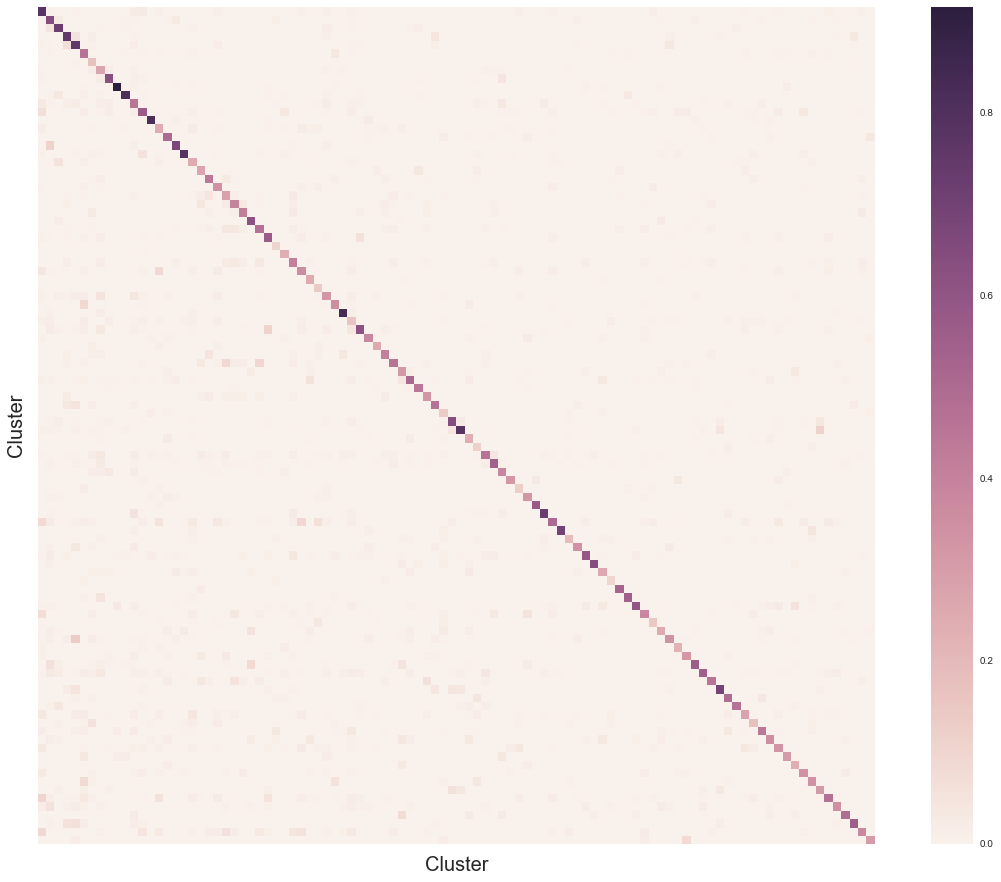

In [420]:
plt.figure(figsize=(20,15))
hm = sns.heatmap(A_norm[0:100, 0:100], square=True)
hm.set_xticklabels([])
hm.set_yticklabels([])
hm.set_xlabel('Cluster', fontsize=20)
hm.set_ylabel('Cluster', fontsize=20)

# OOB error

In [416]:
%%time
min_estimators = 15
max_estimators = 100
if isfile('pickles/rf_n_estimators_oob.pkl'):
    error_rate = pickle.load(open('pickles/rf_n_estimators_oob.pkl', 'rb'))
else:
    # Estimating the optimal number of trees for random forests using OOB error (whatever that is)
    rf_params = random_search.best_params_
    best_params.update({'warm_start':True, 'oob_score':True})
    clf = RandomForestClassifier(**best_params)
    error_rate = []
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)
        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate.append((i, oob_error))
    with open('pickles/rf_n_estimators_oob.pkl', 'wb') as fl:
        pickle.dump(error_rate, fl)

Wall time: 14 ms


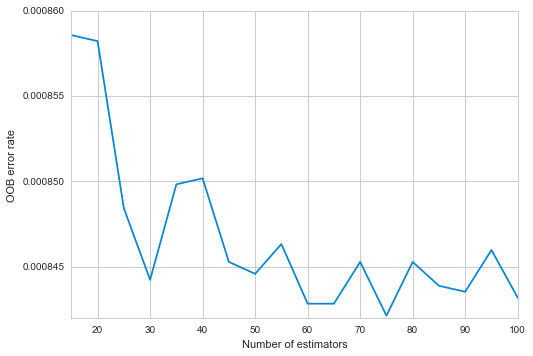

NameError: name 'best_params' is not defined

In [422]:
xs, ys = zip(*error_rate)
plt.plot(xs, ys, color=cerulean)
plt.xlim(15, max_estimators)
plt.xlabel("Number of estimators")
plt.ylabel("OOB error rate")
plt.show()
best_params.update({'n_estimators': 30})

# Unsupervised results

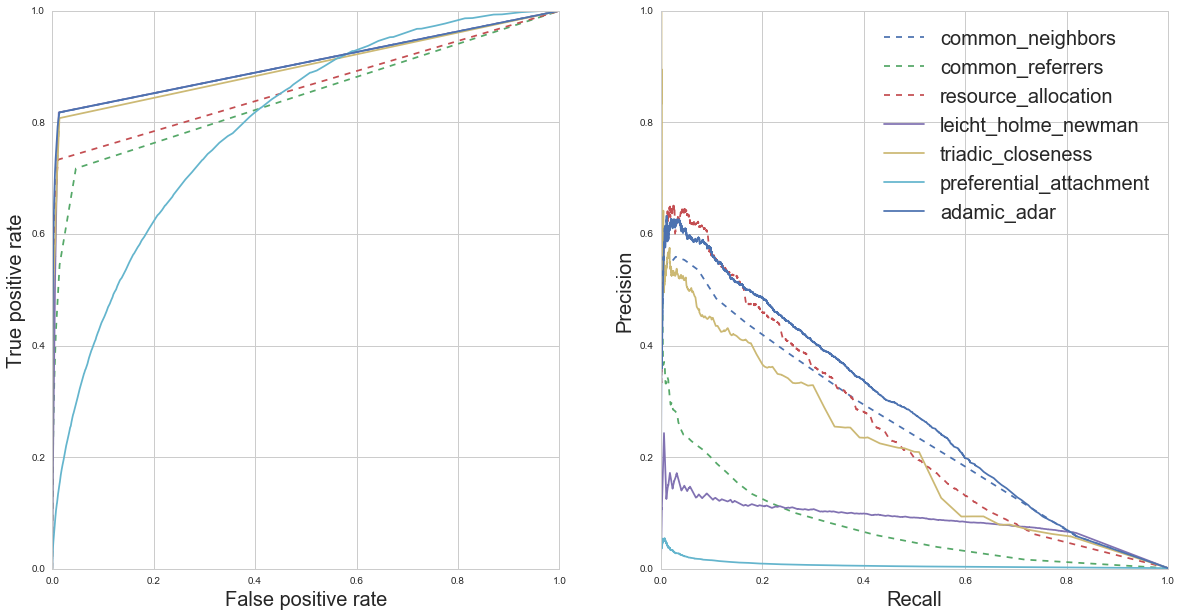

In [564]:
plt.figure(figsize=(20,10))
# Plot ROC curves
plt.subplot(1,2,1)
cn_res = X_train.loc[:, 'common_neighbors']
fpr, tpr, cn_roc_thresh = roc_curve(y_train, cn_res, pos_label=1)
plt.plot(fpr, tpr, '--')
cr_res = X_train.loc[:, 'common_referrers']
fpr, tpr, _ = roc_curve(y_train, cr_res, pos_label=1)
plt.plot(fpr, tpr, ls='--')
ra_res = X_train.loc[:, 'resource_allocation']
fpr, tpr, _ = roc_curve(y_train, ra_res, pos_label=1)
plt.plot(fpr, tpr, ls='--')
ra_res = X_train.loc[:, 'leicht_holme_newman']
fpr, tpr, _ = roc_curve(y_train, ra_res, pos_label=1)
plt.plot(fpr, tpr)
ra_res = X_train.loc[:, 'triadic_closeness']
fpr, tpr, _ = roc_curve(y_train, ra_res, pos_label=1)
plt.plot(fpr, tpr)
ra_res = X_train.loc[:, 'preferential_attachment']
fpr, tpr, pa_roc_thresh = roc_curve(y_train, ra_res, pos_label=1)
plt.plot(fpr, tpr)
ra_res = X_train.loc[:, 'adamic_adar']
fpr, tpr, _ = roc_curve(y_train, ra_res, pos_label=1)
plt.plot(fpr, tpr)
#ra_res = -1*X_test.loc[:, 'shortest_path']
#sp_fpr, sp_tpr, sp_thresh_roc = roc_curve(y_test, ra_res, pos_label=1)
#plt.plot(sp_fpr, sp_tpr)
plt.ylabel('True positive rate', fontsize=20)
plt.xlabel('False positive rate', fontsize=20)

# Plot precision recall curves
plt.subplot(1,2,2)
cn_res = X_train.loc[:, 'common_neighbors']
prec, reca, cn_pr_thresh = precision_recall_curve(y_train, cn_res, pos_label=1)
plt.plot(reca, prec, '--')
cr_res = X_train.loc[:, 'common_referrers']
prec, reca, cr_t_ = precision_recall_curve(y_train, cr_res, pos_label=1)
plt.plot(reca, prec, ls='--')
ra_res = X_train.loc[:, 'resource_allocation']
prec, reca, cr_t_ = precision_recall_curve(y_train, ra_res, pos_label=1)
plt.plot(reca, prec, ls='--')
lhn_res = X_train.loc[:, 'leicht_holme_newman']
prec, reca, cr_t_ = precision_recall_curve(y_train, lhn_res, pos_label=1)
plt.plot(reca, prec)
tc_res = X_train.loc[:, 'triadic_closeness']
prec, reca, cr_t_ = precision_recall_curve(y_train, tc_res, pos_label=1)
plt.plot(reca, prec)
pa_res = X_train.loc[:, 'preferential_attachment']
prec, reca, pa_pr_thresh = precision_recall_curve(y_train, pa_res, pos_label=1)
plt.plot(reca, prec)
aa_res = X_train.loc[:, 'adamic_adar']
prec, reca, cr_t_ = precision_recall_curve(y_train, aa_res, pos_label=1)
plt.plot(reca, prec)
#ra_res = -1*X_test.loc[:, 'shortest_path']
#sp_prec, sp_reca, sp_thresh_pr = precision_recall_curve(y_test, ra_res, pos_label=1)
#plt.plot(sp_reca, sp_prec)
plt.legend(['common_neighbors', 'common_referrers', 'resource_allocation', 
            'leicht_holme_newman', 'triadic_closeness', 'preferential_attachment', 
            'adamic_adar'], fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.xlabel('Recall', fontsize=20)
plt.show()

In [31]:
precisions = defaultdict(list)
indices = ['common_in_neighbors', 'common_out_neighbors', 'common_neighbors', 'common_referrers', 
           'adamic_adar', 'adamic_adar_in', 'adamic_adar_out', 'resource_allocation', 'resource_allocation_out',
          'leicht_holme_newman', 'preferential_attachment', 'tf_idf']
for index in indices:
    precisions['index'].append(index.replace('_', ' ').title())
    scores = X_test.loc[:, index]/(1.0*X_test.loc[:, index].max())
    precisions['ROC-AUC'].append(roc_auc_score(y_test, scores))
    precisions['PR-AUC'].append(average_precision_score(y_test, scores))

In [32]:
print pd.DataFrame(precisions, index = precisions['index']).loc[:, ['PR-AUC', 'ROC-AUC']].to_latex()

\begin{tabular}{lrr}
\toprule
{} &    PR-AUC &   ROC-AUC \\
\midrule
Common In Neighbors     &  0.134029 &  0.763497 \\
Common Out Neighbors    &  0.125359 &  0.770168 \\
Common Neighbors        &  0.197042 &  0.889394 \\
Common Referrers        &  0.068906 &  0.841850 \\
Adamic Adar             &  0.220850 &  0.890019 \\
Adamic Adar In          &  0.155829 &  0.763917 \\
Adamic Adar Out         &  0.132263 &  0.770414 \\
Resource Allocation     &  0.219518 &  0.889958 \\
Resource Allocation Out &  0.132629 &  0.770442 \\
Leicht Holme Newman     &  0.077307 &  0.888402 \\
Preferential Attachment &  0.005336 &  0.786817 \\
Tf Idf                  &  0.039101 &  0.811401 \\
\bottomrule
\end{tabular}



In [74]:
def sorted_scores(indexed_scores, y, G):
    # Get the class probabilities for the test data set along with the source node and the target node
    rf_preds = [(k[0], (k[1], v[1])) for k,v in indexed_scores]

    # Sort the predictions by probability and store them indexed by node
    srt_preds = {}
    for src, edge in rf_preds:
        trg = edge[0]
        prob = edge[1]
        if src not in srt_preds.keys():
            srt_preds[src] = []
        srt_preds[src].append(((src,trg), prob, y[src, trg]))
    for src, predictions in srt_preds.iteritems():
        srt_preds[src] = np.array(sorted(predictions, key=lambda x: x[1], reverse=True))
    # Find the median position of real edges in the sorted predictions
    ranked_medians = np.array([(node, np.median(np.nonzero(vals[:,2])), len(G[node])) 
                             for node, vals in srt_preds.iteritems() 
                             if vals[:,2].any()], dtype='object')
    return ranked_medians

In [593]:
preds = rfe_forest.predict_proba(X_test_cn)


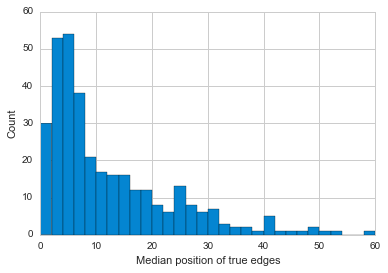

In [81]:
rank_medians = sorted_scores(zip(X_test_cn.index, cn_preds), y_test_cn, GCC)
n_bins = 30
n, bins, patches=plt.hist(rank_medians[:,1].astype('float64'), bins=n_bins, range=(0,60), color=cerulean)
plt.ylabel('Count')
plt.xlabel('Median position of true edges')

In [84]:
sum(n[0:9])/(1.0*sum(n))

0.76035502958579881

In [ ]:
plt.loglog(sorted(d_in, reverse=True), label='In degree')
plt.loglog(sorted(d_out, reverse=True), label='Out degree')
plt.legend()

In [ ]:
res = pd.read_pickle('pickles/cjeu_2012_time_difference.pkl')

In [ ]:
cand_edges = GCC.edges(data=True)
df = pd.DataFrame(index=[(x,y) for x,y,_ in cand_edges])

In [ ]:
df['src_degree'] = pd.Series([len(GCC[x]) - 1 for x, _, __ in cand_edges], 
                             index=[(x,y) for x,y, _ in cand_edges], dtype='uint16')

In [41]:
%%time
# Partition the edges
# Find the edges belonging to the test candidates that have a degree higher than 1
deg_over_two = [n for n,d in GCC.out_degree().iteritems() if d > 1]
removable_edges = GCC.edges(deg_over_two)
# Partition the edges
n_partitions = 3
edge_partitions = np.array_split(removable_edges, n_partitions)
G_dec = GCC.copy()
G_dec.remove_edges_from(edge_partitions[0])
# Prepare a single year test set
test_year = 2013
GRAPH = 'cjeu'
nodes_test = [n[0] for n in slice_graph_by_year(test_year, test_year, GCC)]
# Create a training set
G_train_dec = G_dec.copy()
G_train_dec.remove_nodes_from(nodes_test)
test_candidates = [(source, target, {}) for target in GCC.nodes() for source in nodes_test 
                   if source !=target]
test_data = get_features(GCC, test_candidates, str(test_year) + "_part_{}".format(n_partitions))
X_test_dec = test_data.ix[:, [col for col in test_data.columns if col not in ['edge', 'source', 'target']]]
y_test_dec = test_data['edge']
del test_data

Wall time: 19min 40s


In [42]:
# Training set consisting of the nodes of the preceding year
train_year = 2012
nodes_train = [n[0] for n in slice_graph_by_year(train_year, train_year, G_train_dec)]
train_candidates = [(source, target,{}) for target in G_train_dec.nodes() for source in nodes_train if not source==target]
train_data = get_features(G_train_dec, train_candidates, str(train_year) + "_part_{}".format(n_partitions))
y_train_dec = train_data['edge']
X_train_dec = train_data.loc[:, [col for col in train_data.columns if col not in ['edge', 'source', 'target']]]

In [44]:
# Create a subsampled training set for edges with common neighbors
ind = X_train_dec.loc[:, 'common_neighbors'] > 0
X_train_cn_dec = X_train_dec.loc[~y_train_dec, :].loc[ind, :]
X_train_cn_dec = X_train_cn_dec.sample(9*np.count_nonzero(y_train_dec.loc[ind]), weights=X_train_cn_dec['common_neighbors']**2)
y_train_cn_dec = y_train_dec.loc[X_train_cn_dec.index]

In [45]:
assert(np.count_nonzero(y_train_cn_dec) == 0)
X_train_cn_dec = pd.concat([X_train_dec.loc[y_train_dec,:].loc[ind,:], X_train_cn_dec])
y_train_cn_dec = pd.concat([y_train_dec[y_train_dec].loc[ind], y_train_cn_dec])

print "Class imbalance with common neighbors: {:.4f}".format(1.0*np.count_nonzero(y_train_cn)/len(y_train_cn))
print "True edges: {}, Total edges: {}".format(np.count_nonzero(y_train_cn), len(y_train_cn))
# Create a subsampled test set for edges with common neighbors
ind = X_test_dec.loc[:, 'common_neighbors'] > 0
X_test_cn_dec = X_test_dec.loc[ind, rfe_forest.support_]
y_test_cn_dec = y_test_dec.loc[ind]

Class imbalance with common neighbors: 0.1000
True edges: 7296, Total edges: 72960


In [46]:
rf_dec = RandomForestClassifier(**best_params).fit(X_train_cn_dec, y_train_cn_dec)

In [64]:
preds_dec = rf_dec.predict_proba(X_test_cn_dec)

In [94]:
cn_preds = rfe_forest.predict_proba(X_test_cn)

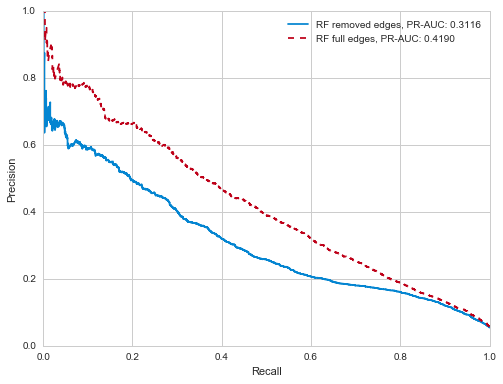

In [96]:
plt.figure(figsize=(8,6))
prec, reca, _ = precision_recall_curve(y_test_cn_dec, preds_dec[:,1])
av_prec = average_precision_score(y_test_cn_dec, preds_dec[:,1])
plt.plot(reca, prec, linestyle='-', label="RF removed edges, PR-AUC: {:.4f}".format(av_prec), color=cerulean)
prec, reca, _ = precision_recall_curve(y_test_cn, cn_preds[:,1])
av_prec = average_precision_score(y_test_cn, cn_preds[:,1])
plt.plot(reca, prec, linestyle='--', label="RF full edges, PR-AUC: {:.4f}".format(av_prec), color=scarlet)
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')

In [88]:
rank_medians = sorted_scores(zip(X_test_cn_dec.index, preds_dec), y_test_cn_dec, G_dec)

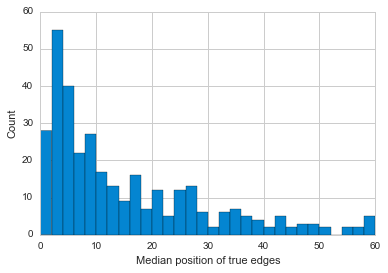

In [89]:
n_bins = 30
n, bins, patches=plt.hist(rank_medians[:,1].astype('float64'), bins=n_bins, range=(0,60), color=cerulean)
plt.ylabel('Count')
plt.xlabel('Median position of true edges')

In [90]:
sum(n[0:9])/(1.0*sum(n))

0.6837349397590361

In [45]:
%%time
# Logistic Regression
# Find hyper-parameters for the regressors
# Try both L1 and L2 regularization with different coefficients
param_grid = [{'penalty': ['l1'], 'solver': ['liblinear']}, {'penalty': ['l2']}]
def scorer(ground_truth, predictions):
    return average_precision_score(ground_truth, predictions[:,1])

Wall time: 0 ns


In [67]:
%%time
print("# Tuning hyper-parameters for AUC-PR")
print()

if isfile('pickles/l2_log_model.pkl'):
    l1_log_model = pickle.load(open('pickles/l2_log_model.pkl', 'rb'))
else:
    # Do an exhaustive search of the entire grid
    l1_log_model = LogisticRegression(penalty='l1', C=1)
    l1_log_model.fit(X_train, y_train)
    with open('pickles/l2_log_model.pkl', 'wb') as fl:
        pickle.dump(l1_log_model, fl)

# Tuning hyper-parameters for AUC-PR
()
Wall time: 66 ms


In [98]:
rf = RandomForestClassifier(**best_params).fit(X_train, y_train)
lr = LogisticRegression(C=1, penalty='l1').fit(X_train, y_train)

In [ ]:
log_model = lr
rf_preds = rf.predict_proba(X_test)
lr_preds = log_model.predict_proba(X_test)

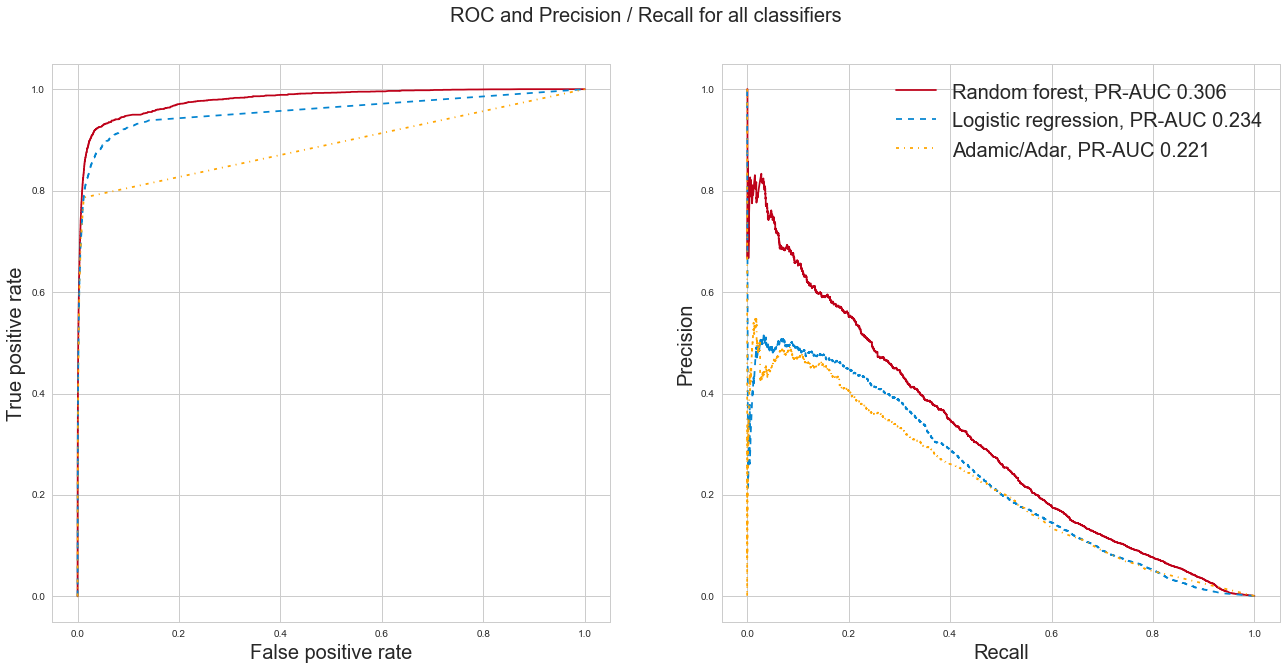

In [118]:
fig=plt.figure(figsize=(22,10))
fig.suptitle('ROC and Precision / Recall for all classifiers', fontsize=20)
ax1 = plt.subplot(1,2,1)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
fpr, tpr, _ = roc_curve(y_test, rf_preds[:,1])
ax1.plot(fpr, tpr, color=scarlet, label='Random forest')
fpr, tpr, _ = roc_curve(y_test, lr_preds[:,1])
ax1.plot(fpr, tpr, '--', color=cerulean, label='Logistic regression')
fpr, tpr, _ = roc_curve(y_test, X_test.loc[:, 'adamic_adar'])
ax1.plot(fpr, tpr, '-.', color='orange', label='Adamic/Adar')
ax1.set_xlabel('False positive rate', fontsize=20)
ax1.set_ylabel('True positive rate', fontsize=20)

ax2 = plt.subplot(1,2,2)
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
mean_avg_precision = average_precision_score(y_test, rf_preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, rf_preds[:,1])
ax2.plot(recall, precision, color=scarlet, label='Random forest, PR-AUC {:.3f}'.format(mean_avg_precision))
mean_avg_precision = average_precision_score(y_test, lr_preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, lr_preds[:,1])
ax2.plot(recall, precision, '--', color=cerulean, label='Logistic regression, PR-AUC {:.3f}'.format(mean_avg_precision))
mean_avg_precision = average_precision_score(y_test, X_test.loc[:, 'adamic_adar'])
precision, recall, thresholds = precision_recall_curve(y_test, X_test.loc[:, 'adamic_adar'])
ax2.plot(recall, precision, '-.', color='orange', label='Adamic/Adar, PR-AUC {:.3f}'.format(mean_avg_precision))
ax2.set_xlabel('Recall', fontsize=20)
ax2.set_ylabel('Precision', fontsize=20)
ax2.legend(fontsize=20)
plt.show()

In [107]:
i = X_train.loc[~y_train, 'common_neighbors'] > 0

In [109]:
1.0*np.count_nonzero(i)/len(i)

0.012666148854565367

In [116]:
len(GCC.selfloop_edges())

87